# Introduction

This file is meant to evaluate the models using Stratified K-Fold with 10 train/test partitions (each train/test partition covers all the dataset). This file is useful to get a better ideia of the real performance of the models by reducing the impact of randomness that a single train/test partition may cause.

Note: This file took around 24 hours to run.

# Imports

In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import VGG16, ResNet50, MobileNetV2
from tensorflow.keras import models, layers
from PerformanceAnalysis import PerformanceAnalysis
from Visualization import Visualization
from DatasetFromDisk import DatasetFromDisk
import json
import os

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Setup

In [2]:
config_file = open('configs\\config.json')
config_vars = json.load(config_file)
config_file.close()

logs_dir = config_vars["logs_dir"] + "/brainTumor_CV"
dataset_dir = config_vars["dataset_dir"]

if not os.path.exists(logs_dir):
    os.makedirs(logs_dir)

In [3]:
config_file = open('configs\\visual_config.json')
config_vars = json.load(config_file)
config_file.close()

shap_colors_neg = config_vars["shap_colors"]["negative"]
shap_colors_pos = config_vars["shap_colors"]["positive"]
shap_colors = np.array([tuple(shap_colors_neg), tuple(shap_colors_pos)])

title_size = config_vars["title_font_size"]
label_size = config_vars["labels_font_size"]

green_color = tuple([x/255 for x in config_vars["green_colors"]["c2"]])

In [4]:
height = 256
width = 256
channels = 3
image_shape = (height, width, channels)
colormap = cv2.COLORMAP_VIRIDIS
data_disk = DatasetFromDisk(height, width, channels, colormap)

In [5]:
# Create the objects to perform performance analysis and visualization
perf_analysis = PerformanceAnalysis()
visual = Visualization()

## Prepare image paths

In [6]:
dataset_folder = f"{dataset_dir}/brain_tumor"

train_folders = [f"{dataset_folder}/images/train/1", f"{dataset_folder}/images/train/2", f"{dataset_folder}/images/train/3"]

test_folders = [f"{dataset_folder}/images/test/1", f"{dataset_folder}/images/test/2", f"{dataset_folder}/images/test/3"]

train_paths = []
train_labels = []

test_paths = []
test_labels = []

cont = 1

for folder in train_folders:
    paths = os.listdir(folder)
    for path in paths:
        train_paths.append(f"{folder}/{path}")
        train_labels.append(cont)
    cont += 1
    
cont = 1

for folder in test_folders:
    paths = os.listdir(folder)
    for path in paths:
        test_paths.append(f"{folder}/{path}")
        test_labels.append(cont)
    cont += 1

## Shuffle paths

In [7]:
X_paths = np.concatenate((train_paths, test_paths))
Y_labels = np.concatenate((train_labels, test_labels))

In [8]:
sss_nsplits = 10
sss = StratifiedShuffleSplit(n_splits=sss_nsplits, test_size=0.2, random_state=42)

lr_clfs = []
lr_limes = []
lr_shaps = []
rf_clfs = []
rf_limes = []
rf_shaps = []
svm_clfs = []
svm_limes = []
svm_shaps = []
ebm_clfs = []

In [9]:
X_trains = []
X_tests = []

batch_size = 32

for i, (train_index, test_index) in enumerate(sss.split(X_paths, Y_labels)):
    train_dataset = tf.data.Dataset.from_tensor_slices((X_paths[train_index], Y_labels[train_index] - 1))
    train_dataset = train_dataset.map(lambda x, y: data_disk.process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    train_dataset = train_dataset.batch(batch_size)
    X_trains.append(train_dataset)
    
    test_dataset = tf.data.Dataset.from_tensor_slices((X_paths[test_index], Y_labels[test_index] - 1))
    test_dataset = test_dataset.map(lambda x, y: data_disk.process_path(x, y), num_parallel_calls=tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size)
    X_tests.append(test_dataset)

### Get examples of the dataset

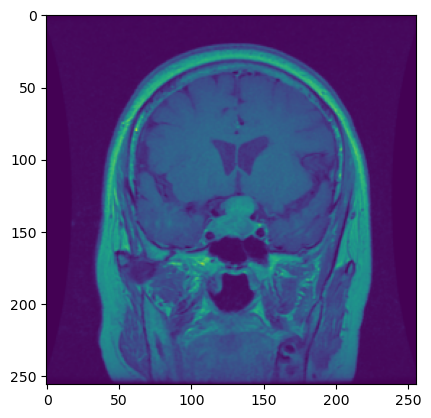

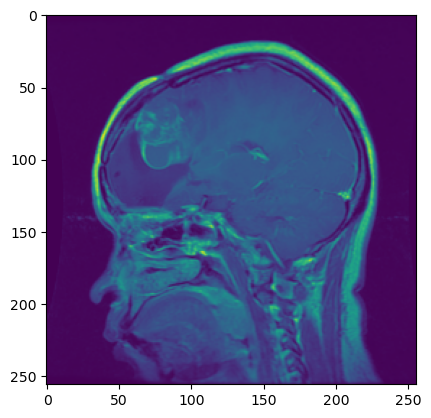

In [10]:
for i, label in X_tests[1].take(2):
    plt.imshow(i[0].numpy())
    plt.show()

# Create Raw Convolutional Neural Network (CNN)

In [62]:
def create_cnn_raw():
    # Define the input shape
    inputs = layers.Input(shape=image_shape)
    
    # Add convolutional layers and pooling layers
    x = layers.Conv2D(16, (3, 3), activation='relu')(inputs)
    x = layers.Conv2D(16, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((3, 3))(x)
    
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.Conv2D(32, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((3, 3))(x)
    
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu')(x)
    x = layers.MaxPooling2D((2, 2))(x)
    
    # Flatten the output of the last convolutional layer
    x = layers.Flatten()(x)
    
    # Add dense layers
    x = layers.Dense(512, activation='relu')(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    
    # Create the model
    cnn_raw = models.Model(inputs=inputs, outputs=outputs)
    
    opt = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
    beta_2=0.99)
    
    cnn_raw.compile(loss="sparse_categorical_crossentropy",
    optimizer=opt, metrics=["accuracy"])
    
    return cnn_raw

## Calculate Metrics

In [63]:
cnn_raw_cms = []
cnn_raw_metrics = []


for split in range(sss_nsplits):
    cnn_raw = create_cnn_raw()
    cnn_raw.fit(X_trains[split], epochs=10)
    
    # Predict on the entire test dataset
    all_predictions = []
    all_labels = []
    
    for images, labels in X_tests[split]:
        predictions = cnn_raw.predict(images, verbose=0)
        all_predictions.append(predictions)
        all_labels.append(labels)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    predicted_classes = np.argmax(all_predictions, axis=1)
    
    cnn_raw_cm = confusion_matrix(all_labels, predicted_classes)
    cnn_raw_cms.append(cnn_raw_cm)
    
    cnn_raw_metrics.append(perf_analysis.acc_for_class(cnn_raw_cm))

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 69s 828ms/step - accuracy: 0.4286 - loss: 20.2665
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 65s 836ms/step - accuracy: 0.6820 - loss: 0.7117
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 829ms/step - accuracy: 0.7496 - loss: 0.5415
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 820ms/step - accuracy: 0.8051 - loss: 0.4447
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 65s 834ms/step - accuracy: 0.8423 - loss: 0.3894
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 818ms/step - accuracy: 0.8714 - loss: 0.3295
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 820ms/step - accuracy: 0.8496 - loss: 0.3634
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 62s 805ms/step - accuracy: 0.8874 - loss: 0.2544
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 64s 821ms/step - accuracy: 0.8957 - loss: 0.2590
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 63s 808ms/step - accuracy: 0.9051 - loss: 0.2534
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 67s 816ms/step - accuracy: 0.4179 - loss: 96.4607
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 64

### Calculate Means

In [64]:
cnn_raw_metrics_concat = pd.concat(tuple(cnn_raw_metrics[:]), axis=1)
cnn_raw_means = cnn_raw_metrics_concat.mean(axis=1).to_frame()
cnn_raw_means = cnn_raw_means.rename(columns={0: "Raw CNN"})
cnn_raw_means["Raw CNN"] = [round(x, 2) for x in cnn_raw_means["Raw CNN"]]
cnn_raw_means

,Raw CNN
0,0.52
1,0.89
2,0.64
Average,0.68
Accuracy,0.73


### Calculate Standard Deviation

In [65]:
cnn_raw_std = cnn_raw_metrics_concat.std(axis=1).to_frame()
cnn_raw_std = cnn_raw_std.rename(columns={0: "Raw CNN"})
cnn_raw_std["Raw CNN"] = [round(x, 2) for x in cnn_raw_std["Raw CNN"]]
cnn_raw_std

,Raw CNN
0,0.38
1,0.10
2,0.45
Average,0.24
Accuracy,0.18


# Create CNN by Transfer Learning with VGG16

In [66]:
def create_vgg():

    base_model = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)
    
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    
    # Create the new model
    tl_vgg = models.Model(inputs=base_model.input, outputs=predictions)
    
    opt = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
    beta_2=0.99)
    
    tl_vgg.compile(loss="sparse_categorical_crossentropy",
    optimizer=opt, metrics=["accuracy"])
    
    return tl_vgg

## Calculate Metrics

In [67]:
tl_vgg_cms = []
tl_vgg_metrics = []


for split in range(sss_nsplits):
    tl_vgg = create_vgg()
    tl_vgg.fit(X_trains[split], epochs=10)
    
    # Predict on the entire test dataset
    all_predictions = []
    all_labels = []
    
    for images, labels in X_tests[split]:
        predictions = tl_vgg.predict(images, verbose=0)
        all_predictions.append(predictions)
        all_labels.append(labels)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    predicted_classes = np.argmax(all_predictions, axis=1)
    
    tl_vgg_cm = confusion_matrix(all_labels, predicted_classes)
    tl_vgg_cms.append(tl_vgg_cm)
    
    tl_vgg_metrics.append(perf_analysis.acc_for_class(tl_vgg_cm))

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.6416 - loss: 4.0181
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 356s 5s/step - accuracy: 0.8754 - loss: 0.2802
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.9112 - loss: 0.2231
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.9195 - loss: 0.1970
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.9391 - loss: 0.1615
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.9452 - loss: 0.1353
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 360s 5s/step - accuracy: 0.9497 - loss: 0.1393
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.9533 - loss: 0.1339
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.9436 - loss: 0.1472
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0.9580 - loss: 0.0992
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 359s 5s/step - accuracy: 0.6400 - loss: 4.5795
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 357s 5s/step - accuracy: 0

### Calculate Means

In [68]:
tl_vgg_metrics_concat = pd.concat(tuple(tl_vgg_metrics[:]), axis=1)
tl_vgg_means = tl_vgg_metrics_concat.mean(axis=1).to_frame()
tl_vgg_means = tl_vgg_means.rename(columns={0: "VGG"})
tl_vgg_means["VGG"] = [round(x, 2) for x in tl_vgg_means["VGG"]]
tl_vgg_means

,VGG
0,0.69
1,0.93
2,0.94
Average,0.85
Accuracy,0.88


### Calculate Standard Deviation

In [69]:
tl_vgg_std = tl_vgg_metrics_concat.std(axis=1).to_frame()
tl_vgg_std = tl_vgg_std.rename(columns={0: "VGG"})
tl_vgg_std["VGG"] = [round(x, 2) for x in tl_vgg_std["VGG"]]
tl_vgg_std

,VGG
0,0.16
1,0.07
2,0.04
Average,0.04
Accuracy,0.02


# Create CNN by Transfer Learning with MobileNetV2

In [70]:
def create_mbnet():

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)
    
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x)
    
    # Create the new model
    tl_mn = models.Model(inputs=base_model.input, outputs=predictions)
    
    opt = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
    beta_2=0.99)
    
    tl_mn.compile(loss="sparse_categorical_crossentropy",
    optimizer=opt, metrics=["accuracy"])
    
    return tl_mn

## Calculate Metrics

In [71]:
tl_mn_cms = []
tl_mn_metrics = []


for split in range(sss_nsplits):
    tl_mn = create_mbnet()
    tl_mn.fit(X_trains[split], epochs=10)
    
    # Predict on the entire test dataset
    all_predictions = []
    all_labels = []
    
    for images, labels in X_tests[split]:
        predictions = tl_mn.predict(images, verbose=0)
        all_predictions.append(predictions)
        all_labels.append(labels)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    predicted_classes = np.argmax(all_predictions, axis=1)
    
    tl_mn_cm = confusion_matrix(all_labels, predicted_classes)
    tl_mn_cms.append(tl_mn_cm)
    
    tl_mn_metrics.append(perf_analysis.acc_for_class(tl_mn_cm))

`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6305 - loss: 1.9025
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8496 - loss: 0.3666
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8862 - loss: 0.3028
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8951 - loss: 0.2685
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8997 - loss: 0.2424
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9224 - loss: 0.2049
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9292 - loss: 0.1821
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9417 - loss: 0.1616
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9471 - loss: 0.1423
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9553 - loss: 0.1234


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.6127 - loss: 1.8567
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.8302 - loss: 0.4040
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8610 - loss: 0.3359
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8821 - loss: 0.2900
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8989 - loss: 0.2537
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9093 - loss: 0.2258
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9239 - loss: 0.1921
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9359 - loss: 0.1707
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9442 - loss: 0.1416
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9495 - loss: 0.1262


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6086 - loss: 1.7934
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8488 - loss: 0.3601
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8896 - loss: 0.2869
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8964 - loss: 0.2493
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9072 - loss: 0.2223
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9185 - loss: 0.2008
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9273 - loss: 0.1799
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9344 - loss: 0.1546
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9448 - loss: 0.1401
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9503 - loss: 0.1238


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6072 - loss: 2.0688
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8446 - loss: 0.3825
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8675 - loss: 0.3210
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8929 - loss: 0.2784
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9025 - loss: 0.2494
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9135 - loss: 0.2196
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9253 - loss: 0.1985
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9318 - loss: 0.1698
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9433 - loss: 0.1557
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9486 - loss: 0.1326


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.6337 - loss: 1.6478
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8519 - loss: 0.3474
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8802 - loss: 0.2760
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9046 - loss: 0.2289
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9226 - loss: 0.2002
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9263 - loss: 0.1816
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9373 - loss: 0.1579
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9427 - loss: 0.1446
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9434 - loss: 0.1375
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9540 - loss: 0.1132


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6062 - loss: 1.9685
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8635 - loss: 0.3425
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8854 - loss: 0.2797
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9088 - loss: 0.2379
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9179 - loss: 0.2096
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9294 - loss: 0.1819
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9322 - loss: 0.1668
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9490 - loss: 0.1482
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9517 - loss: 0.1262
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9592 - loss: 0.1162


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6221 - loss: 1.8938
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8523 - loss: 0.3573
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8969 - loss: 0.2861
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9072 - loss: 0.2454
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9261 - loss: 0.2053
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9327 - loss: 0.1816
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9366 - loss: 0.1649
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9388 - loss: 0.1515
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9331 - loss: 0.1510
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9413 - loss: 0.1316


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.6510 - loss: 1.7268
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8513 - loss: 0.3614
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8856 - loss: 0.3008
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8995 - loss: 0.2628
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9107 - loss: 0.2272
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9166 - loss: 0.2018
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9235 - loss: 0.1837
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9396 - loss: 0.1647
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9439 - loss: 0.1556
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9349 - loss: 0.1618


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.5929 - loss: 1.8296
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8623 - loss: 0.3475
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8786 - loss: 0.2836
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9022 - loss: 0.2354
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9158 - loss: 0.2036
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.9293 - loss: 0.1792
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9422 - loss: 0.1576
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9533 - loss: 0.1365
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9601 - loss: 0.1211
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9618 - loss: 0.1099


`input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.


Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.6189 - loss: 1.8716
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8553 - loss: 0.3336
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.8954 - loss: 0.2680
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 97s 1s/step - accuracy: 0.9115 - loss: 0.2293
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9212 - loss: 0.1962
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9330 - loss: 0.1744
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9445 - loss: 0.1513
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - accuracy: 0.9442 - loss: 0.1373
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9486 - loss: 0.1230
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9605 - loss: 0.1050


### Calculate Means

In [72]:
tl_mn_metrics_concat = pd.concat(tuple(tl_mn_metrics[:]), axis=1)
tl_mn_means = tl_mn_metrics_concat.mean(axis=1).to_frame()
tl_mn_means = tl_mn_means.rename(columns={0: "MNet"})
tl_mn_means["MNet"] = [round(x, 2) for x in tl_mn_means["MNet"]]
tl_mn_means

,MNet
0,0.77
1,0.88
2,0.93
Average,0.86
Accuracy,0.87


### Calculate Standard Deviation

In [73]:
tl_mn_std = tl_mn_metrics_concat.std(axis=1).to_frame()
tl_mn_std = tl_mn_std.rename(columns={0: "MNet"})
tl_mn_std["MNet"] = [round(x, 2) for x in tl_mn_std["MNet"]]
tl_mn_std

,MNet
0,0.12
1,0.06
2,0.05
Average,0.03
Accuracy,0.02


# Create CNN by Transfer Learning with RESNet50

In [74]:
def create_resnet():
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=image_shape)
    
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False
    
    # Add custom layers
    x = base_model.output
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    predictions = layers.Dense(3, activation='softmax')(x) 
    
    # Create the new model
    tl_rn = models.Model(inputs=base_model.input, outputs=predictions)
    
    opt = keras.optimizers.Nadam(learning_rate=0.005, beta_1=0.9,
    beta_2=0.99)
    
    tl_rn.compile(loss="sparse_categorical_crossentropy",
    optimizer=opt, metrics=["accuracy"])
    
    return tl_rn

## Calculate Metrics

In [75]:
tl_rn_cms = []
tl_rn_metrics = []


for split in range(sss_nsplits):
    tl_rn = create_resnet()
    tl_rn.fit(X_trains[split], epochs=10)
    
    # Predict on the entire test dataset
    all_predictions = []
    all_labels = []
    
    for images, labels in X_tests[split]:
        predictions = tl_rn.predict(images, verbose=0)
        all_predictions.append(predictions)
        all_labels.append(labels)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    predicted_classes = np.argmax(all_predictions, axis=1)
    
    tl_rn_cm = confusion_matrix(all_labels, predicted_classes)
    tl_rn_cms.append(tl_rn_cm)
    
    tl_rn_metrics.append(perf_analysis.acc_for_class(tl_rn_cm))

Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 209s 3s/step - accuracy: 0.6490 - loss: 3.6417
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.8916 - loss: 0.2510
Epoch 3/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9126 - loss: 0.1915
Epoch 4/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9400 - loss: 0.1480
Epoch 5/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.9523 - loss: 0.1173
Epoch 6/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9583 - loss: 0.1008
Epoch 7/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.9468 - loss: 0.1235
Epoch 8/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.9603 - loss: 0.1062
Epoch 9/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.9702 - loss: 0.0677
Epoch 10/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.9653 - loss: 0.0942
Epoch 1/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 205s 3s/step - accuracy: 0.6550 - loss: 3.5703
Epoch 2/10
77/77 ━━━━━━━━━━━━━━━━━━━━ 195s 3s/step - accuracy: 0

### Calculate Means

In [76]:
tl_rn_metrics_concat = pd.concat(tuple(tl_rn_metrics[:]), axis=1)
tl_rn_means = tl_rn_metrics_concat.mean(axis=1).to_frame()
tl_rn_means = tl_rn_means.rename(columns={0: "ResNet"})
tl_rn_means["ResNet"] = [round(x, 2) for x in tl_rn_means["ResNet"]]
tl_rn_means

,ResNet
0,0.81
1,0.93
2,0.94
Average,0.89
Accuracy,0.90


### Calculate Standard Deviation

In [77]:
tl_rn_std = tl_rn_metrics_concat.std(axis=1).to_frame()
tl_rn_std = tl_rn_std.rename(columns={0: "ResNet"})
tl_rn_std["ResNet"] = [round(x, 2) for x in tl_rn_std["ResNet"]]
tl_rn_std

,ResNet
0,0.09
1,0.06
2,0.03
Average,0.02
Accuracy,0.02


# Summary

## Metrics

### Mean of obtained metrics

In [88]:
overall_metrics_means = pd.concat([cnn_raw_means, tl_vgg_means, tl_mn_means, tl_rn_means], axis=1)
display(overall_metrics_means)

,Raw CNN,VGG,MNet,ResNet
0,0.52,0.69,0.77,0.81
1,0.89,0.93,0.88,0.93
2,0.64,0.94,0.93,0.94
Average,0.68,0.85,0.86,0.89
Accuracy,0.73,0.88,0.87,0.90


### Standard Deviation of obtained metrics

In [89]:
overall_metrics_std = pd.concat([cnn_raw_std, tl_vgg_std, tl_mn_std, tl_rn_std], axis=1)
display(overall_metrics_std)

,Raw CNN,VGG,MNet,ResNet
0,0.38,0.16,0.12,0.09
1,0.10,0.07,0.06,0.06
2,0.45,0.04,0.05,0.03
Average,0.24,0.04,0.03,0.02
Accuracy,0.18,0.02,0.02,0.02


#### Save means in disk

In [90]:
latex_str = "Classes"  + ''.join([" & " + x for x in overall_metrics_means.columns]) + " \\\ \n"

In [91]:
for i, row in overall_metrics_means.iterrows():
    
    aux_str = str(i)
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/brain_tumor_metrics_means.txt", "w") as text_file:
    print(latex_str, file=text_file)

#### Save standard deviations in disk

In [92]:
latex_str = "Classes"  + ''.join([" & " + x for x in overall_metrics_std.columns]) + " \\\ \n"

In [93]:
for i, row in overall_metrics_std.iterrows():
    
    aux_str = str(i)
    for k in row:
        aux_str += f" & {k}"
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/brain_tumor_metrics_std.txt", "w") as text_file:
    print(latex_str, file=text_file)

#### Save means with std in disk

In [94]:
latex_str = "Classes"  + ''.join([" & " + x for x in overall_metrics_means.columns]) + " \\\ \n"

In [95]:
for i, row in overall_metrics_means.iterrows():
    
    aux_str = str(i)
    
    cont = 0
    for k in row:
        aux_str += f" & {k} $\\pm$ {overall_metrics_std.loc[[i]].iloc[0].iloc[cont]}"
        cont += 1
    
    latex_str += aux_str + " \\\ \n"

with open(f"{logs_dir}/brain_tumor_metrics_means_wstd.txt", "w") as text_file:
    print(latex_str, file=text_file)

## Visual Accuracy per class

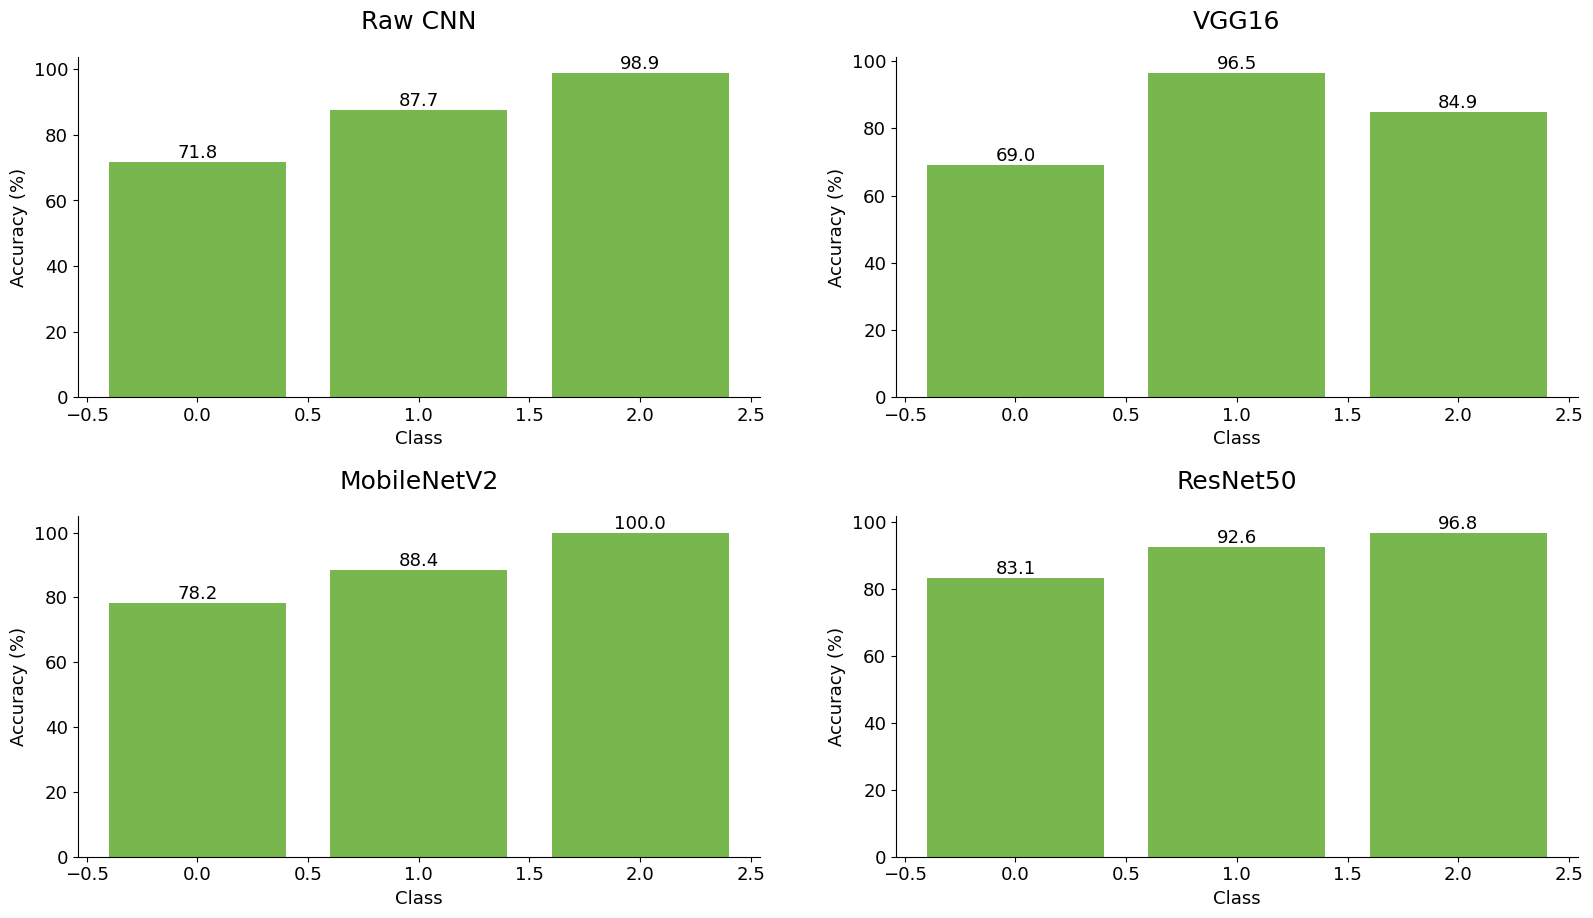

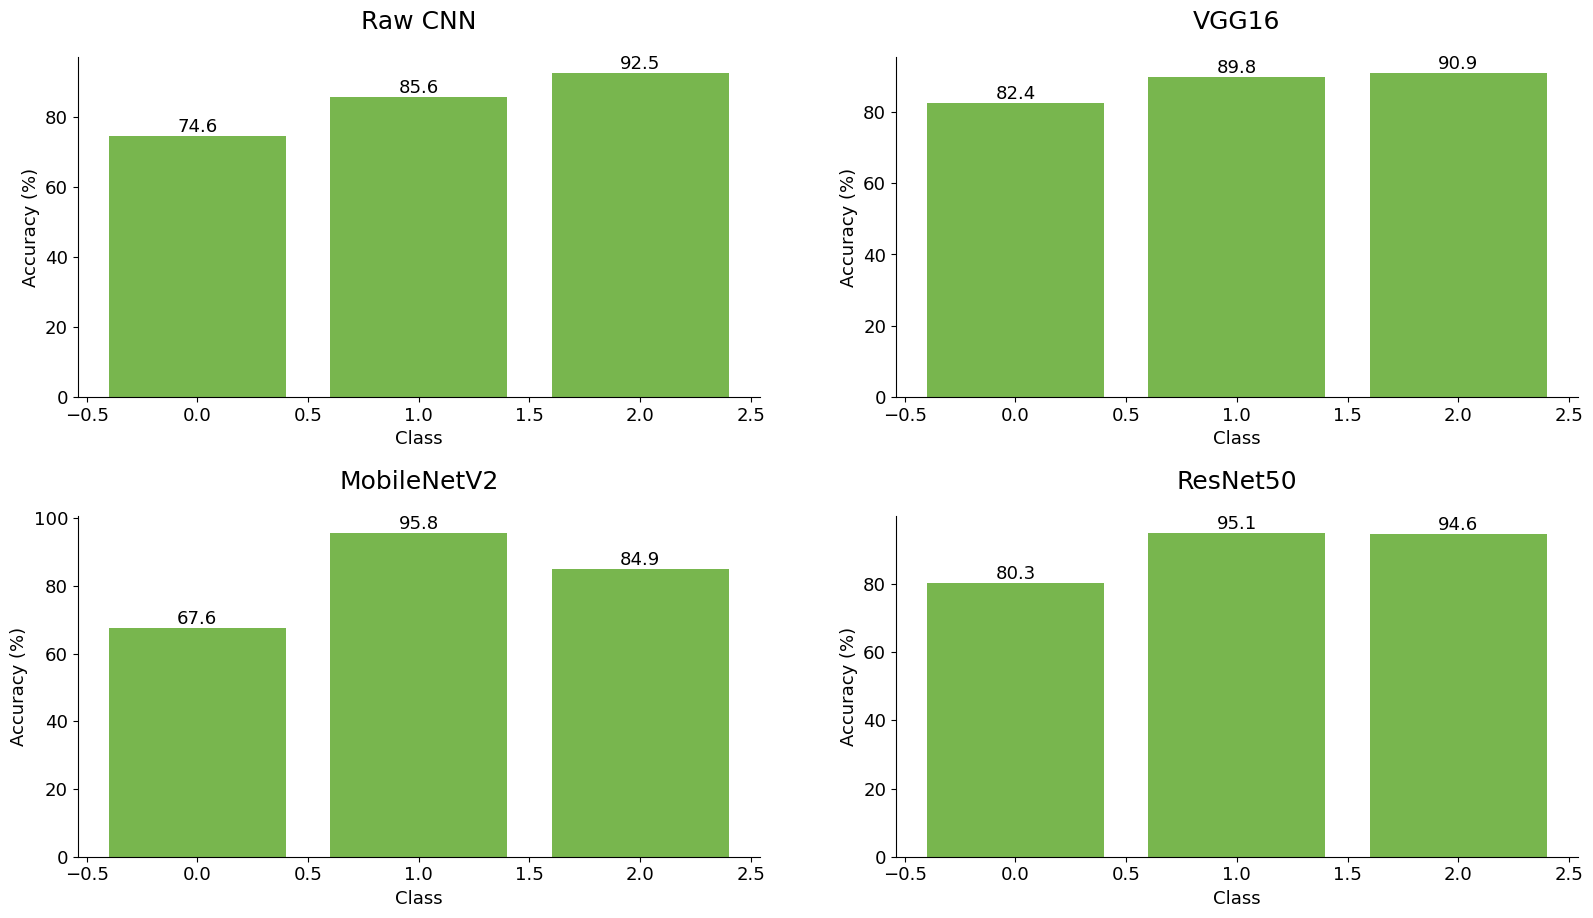

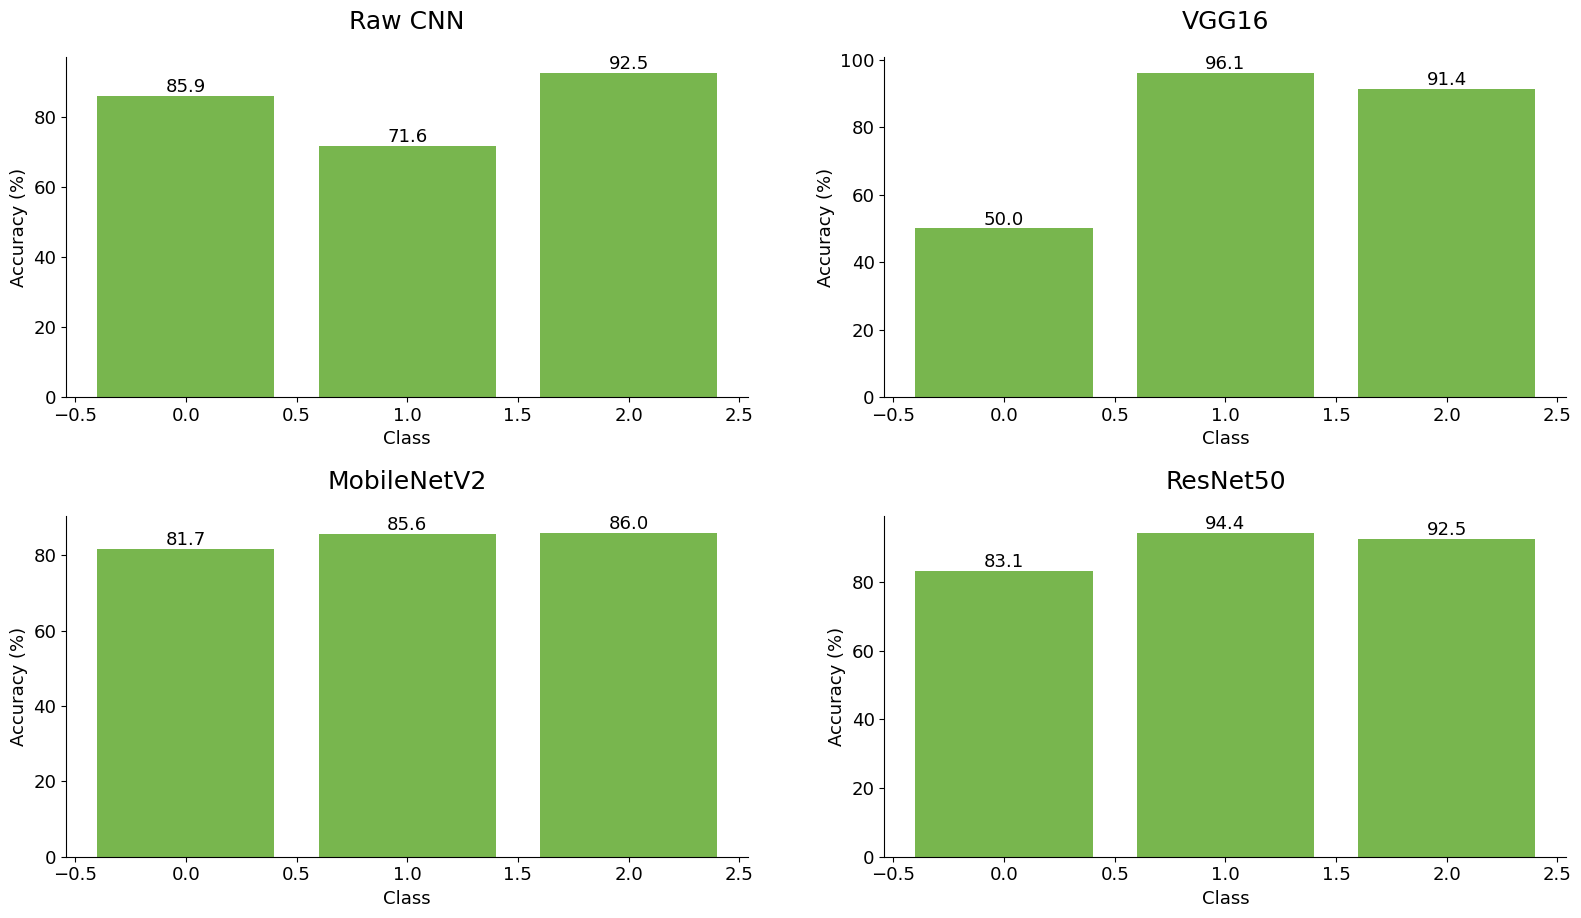

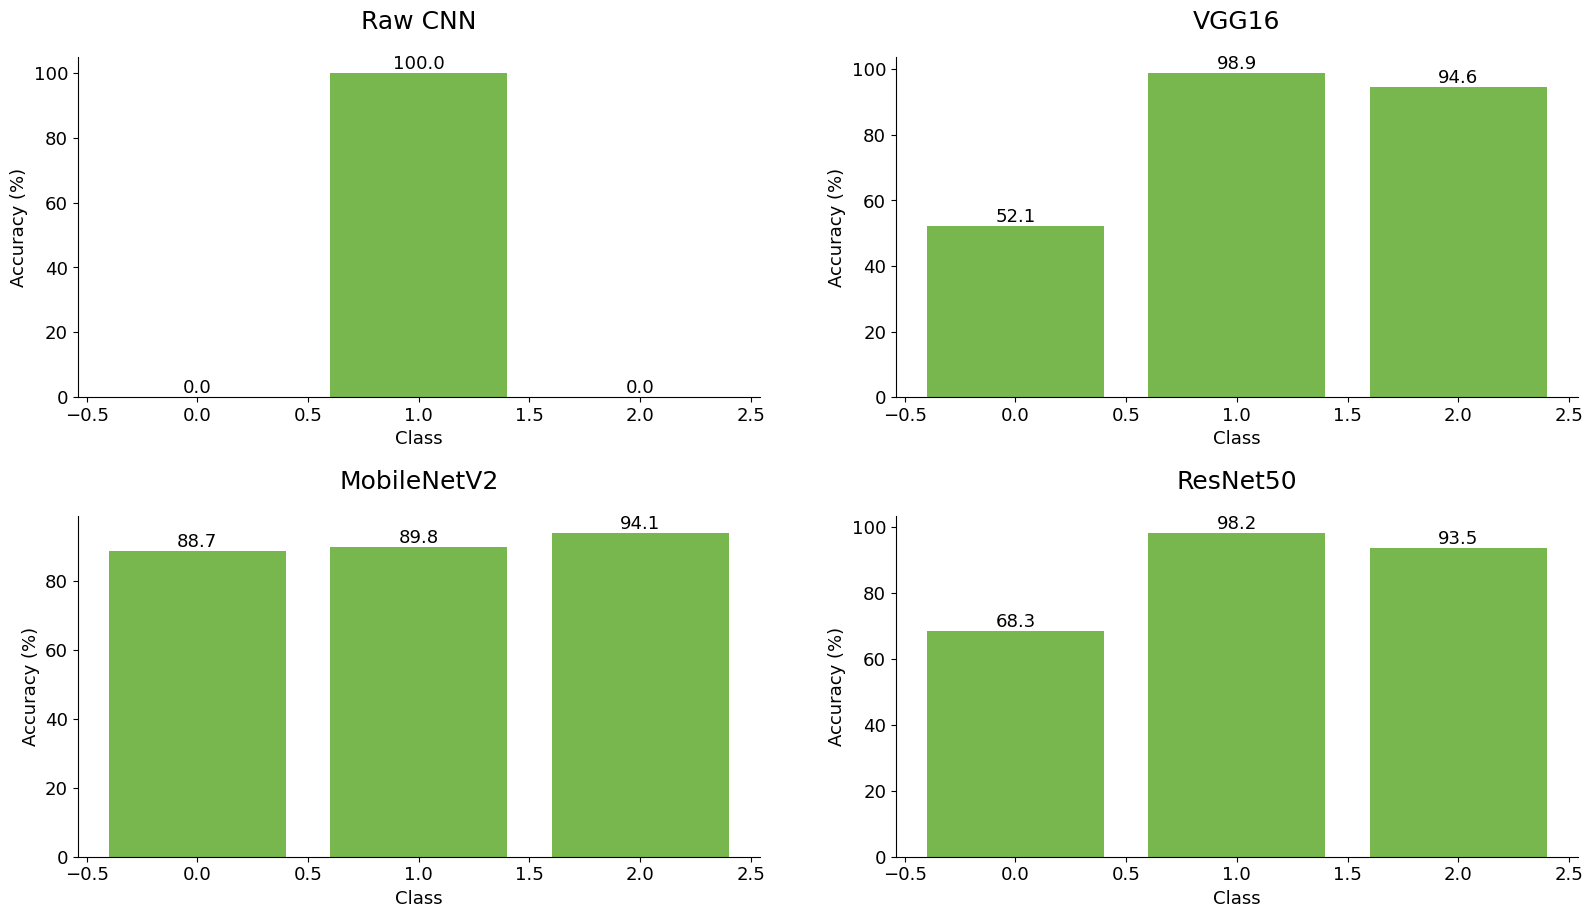

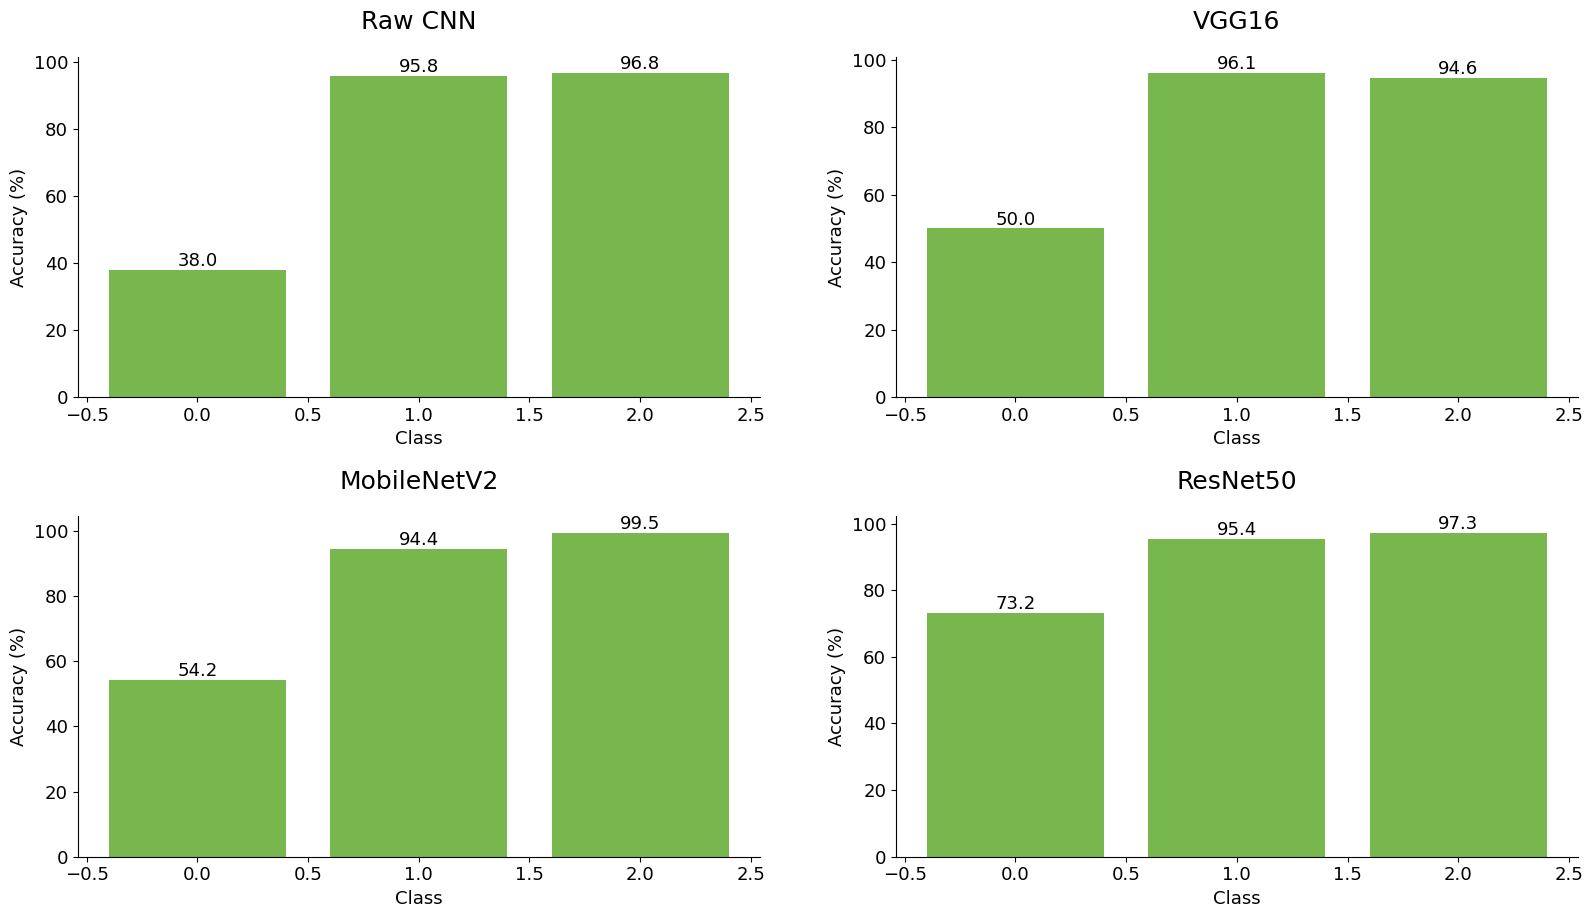

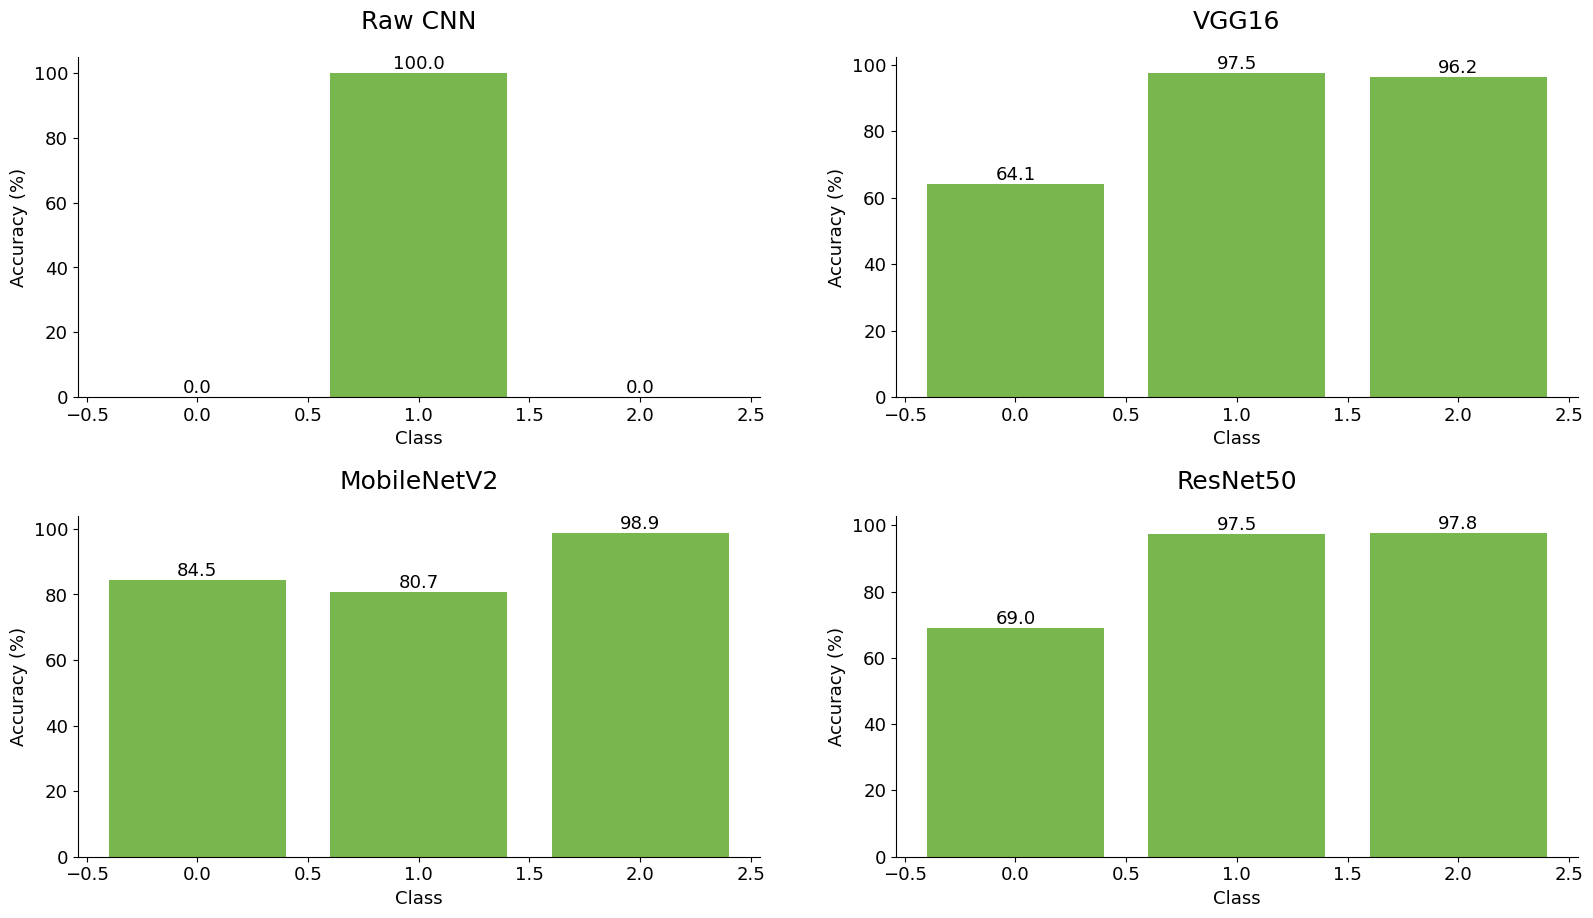

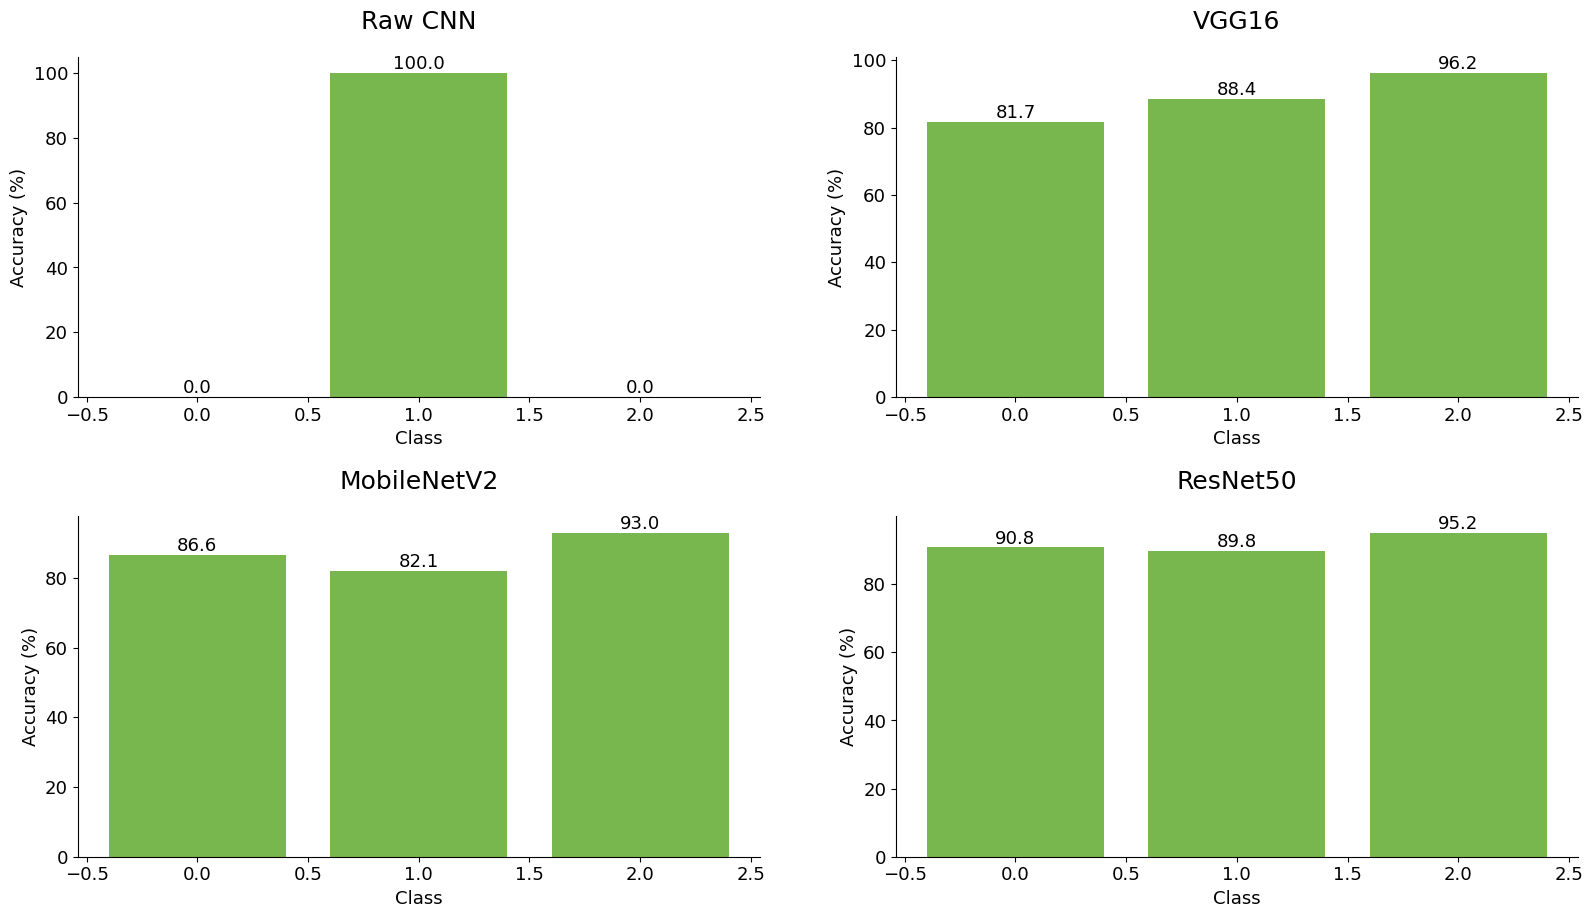

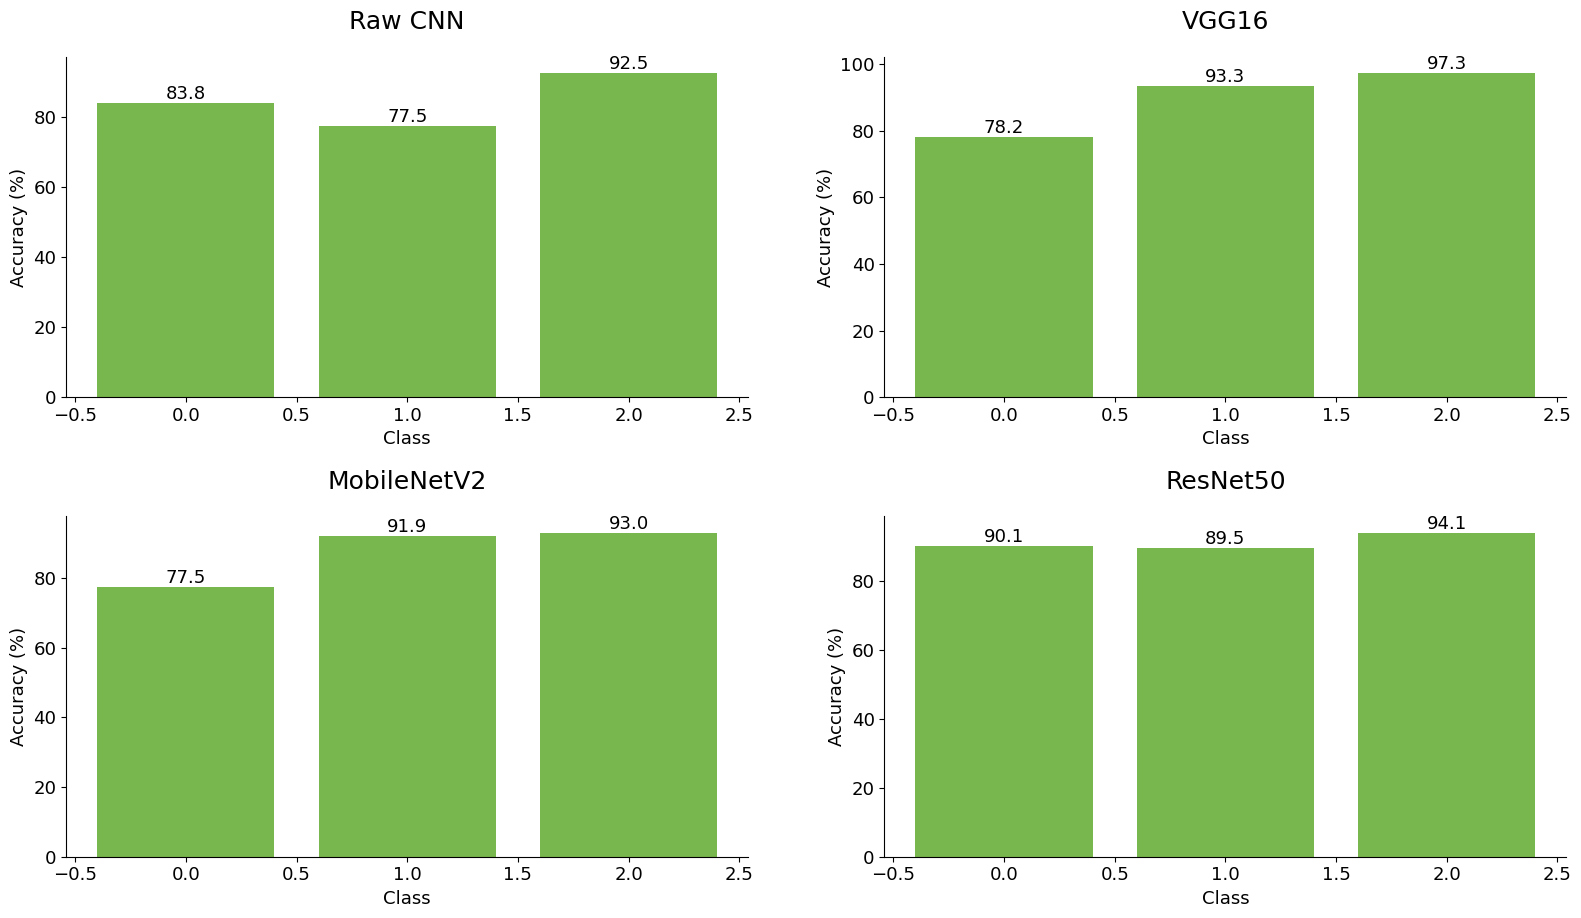

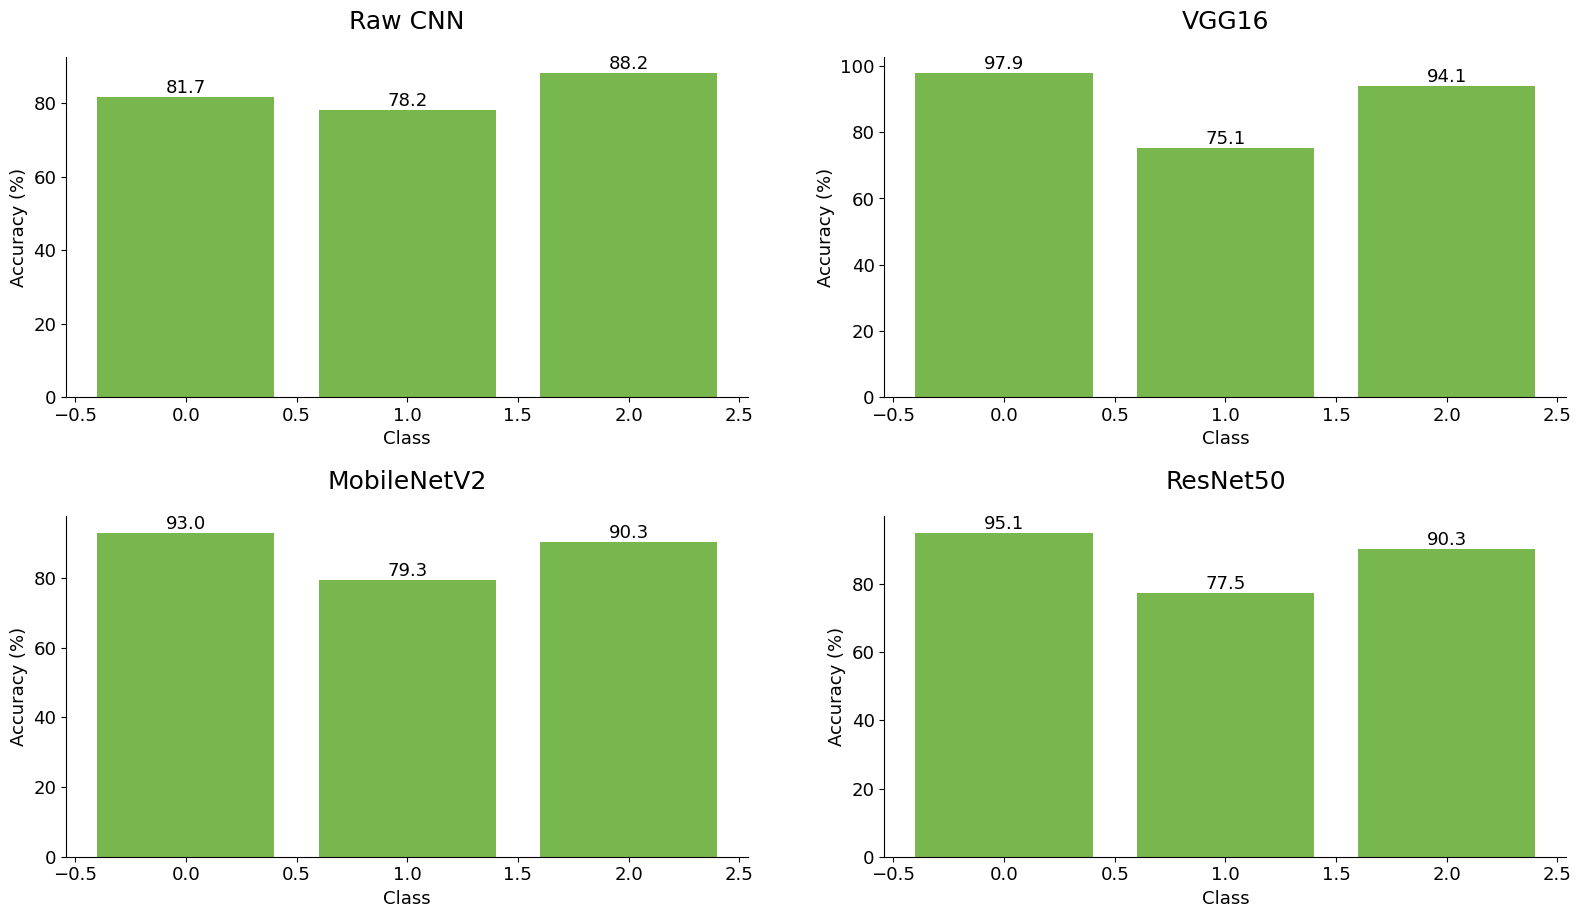

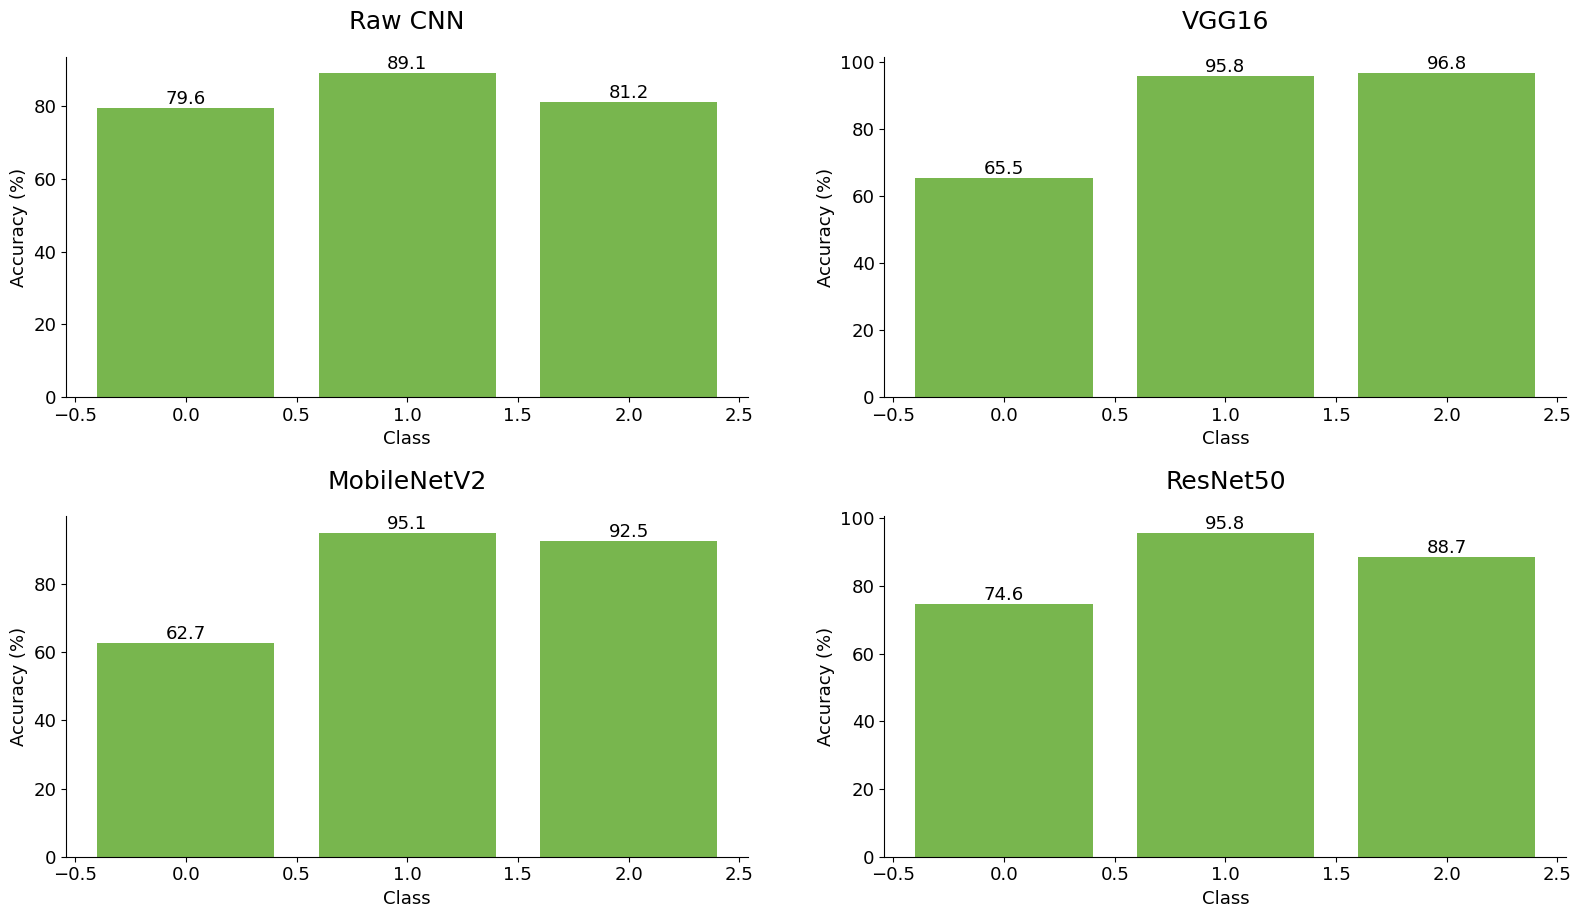

In [96]:
for split in range(sss_nsplits):

    visual.acc_classes([cnn_raw_cms[split], tl_vgg_cms[split], tl_mn_cms[split], tl_rn_cms[split]],
                      nrows=2, 
                      ncols=2, 
                      figsize=(15,8),
                      title_size=title_size,
                      label_size=label_size,
                      colors=[green_color, green_color, green_color, green_color],
                      titles=["Raw CNN", "VGG16", "MobileNetV2", "ResNet50"])
    
    plt.savefig(f"{logs_dir}/brain_tumor_acc_classes_{split}.png", bbox_inches="tight")
    
    plt.show()

## Confusion Matrices

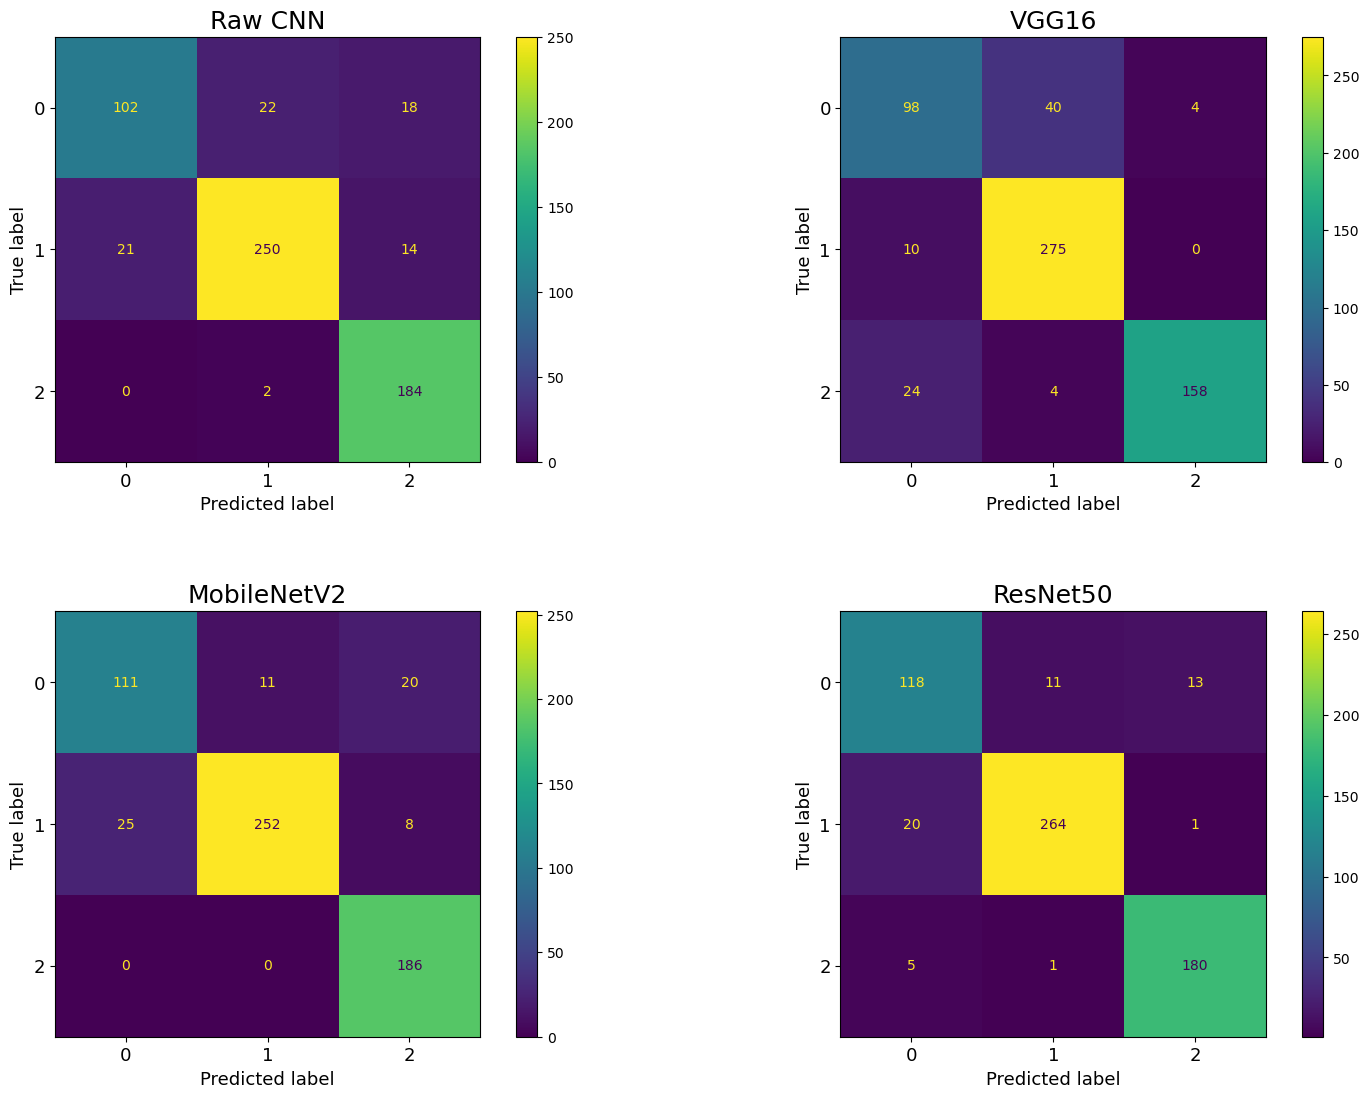

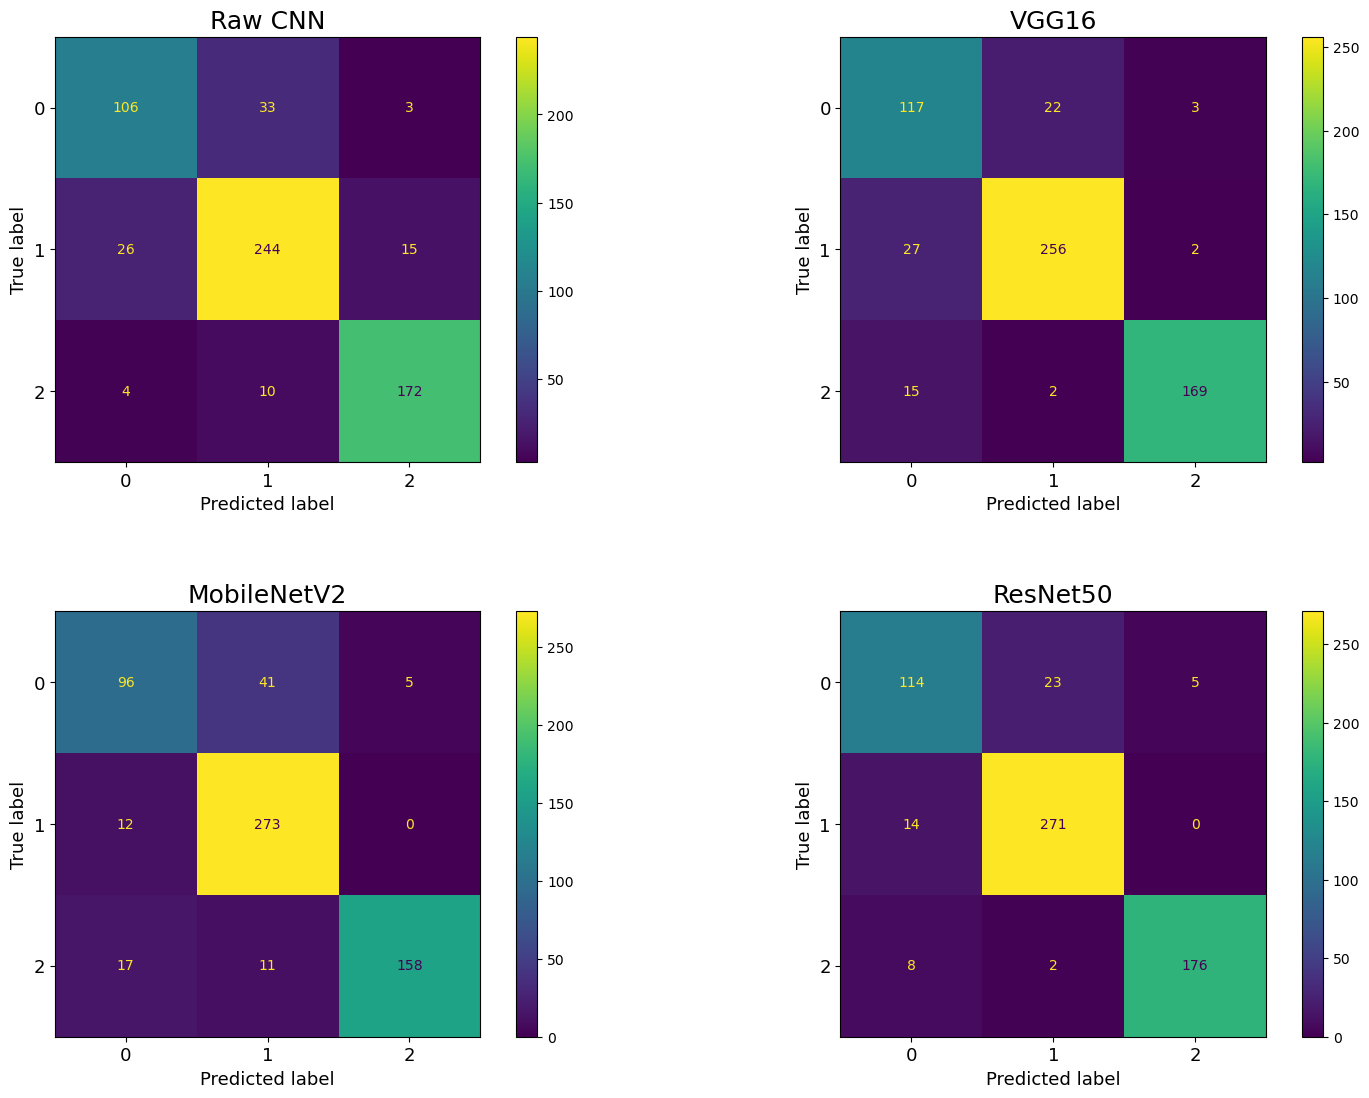

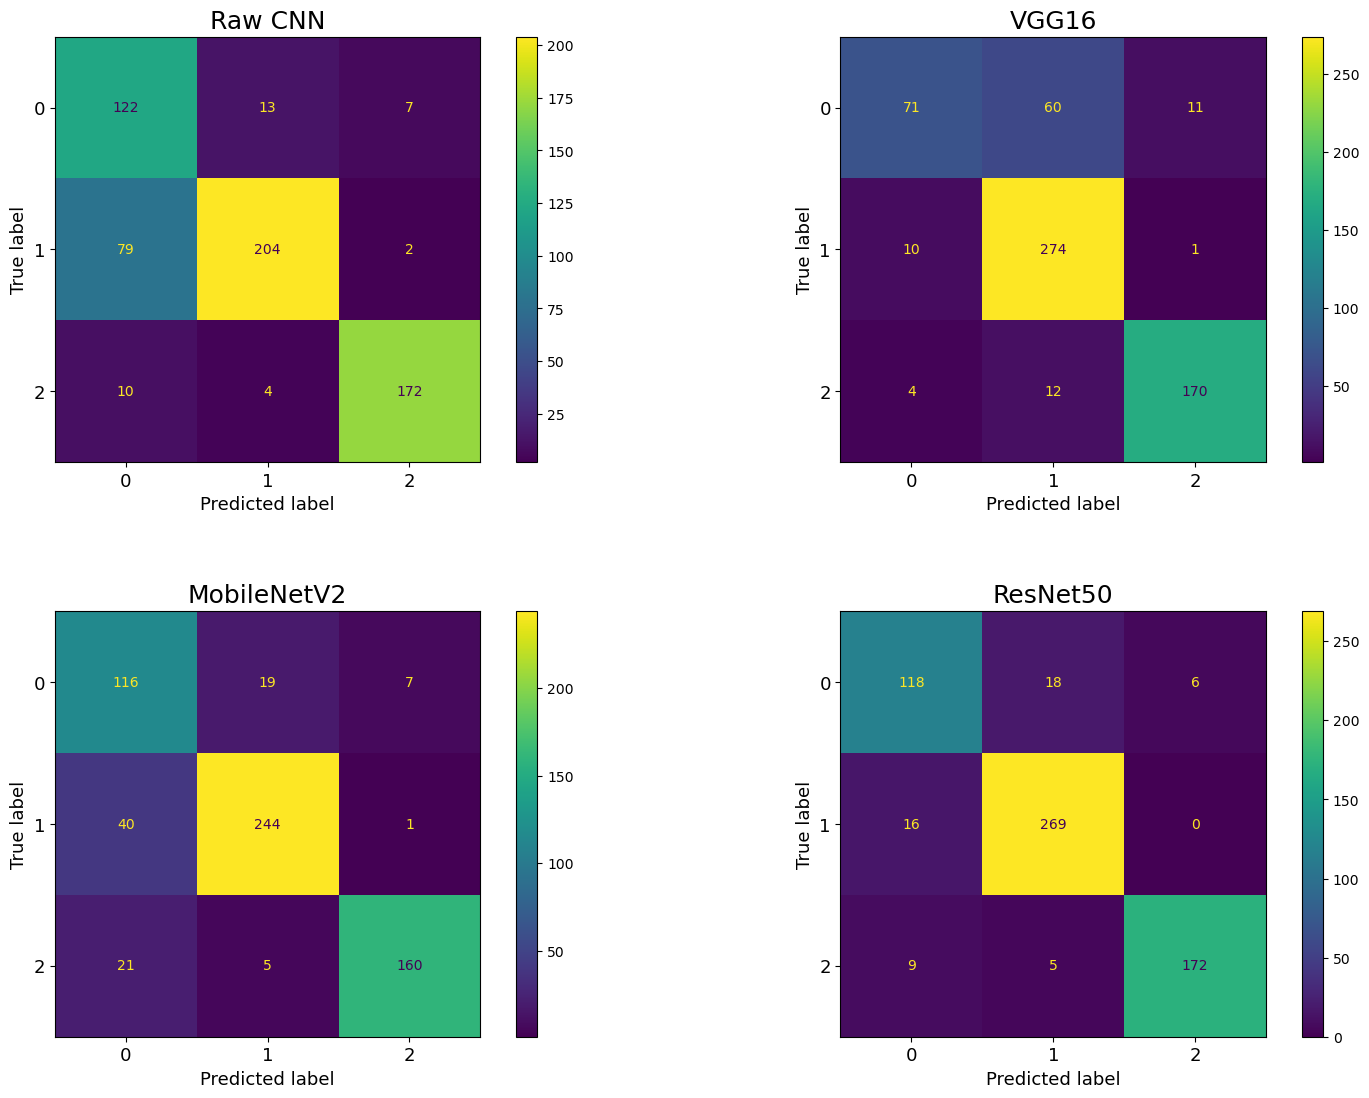

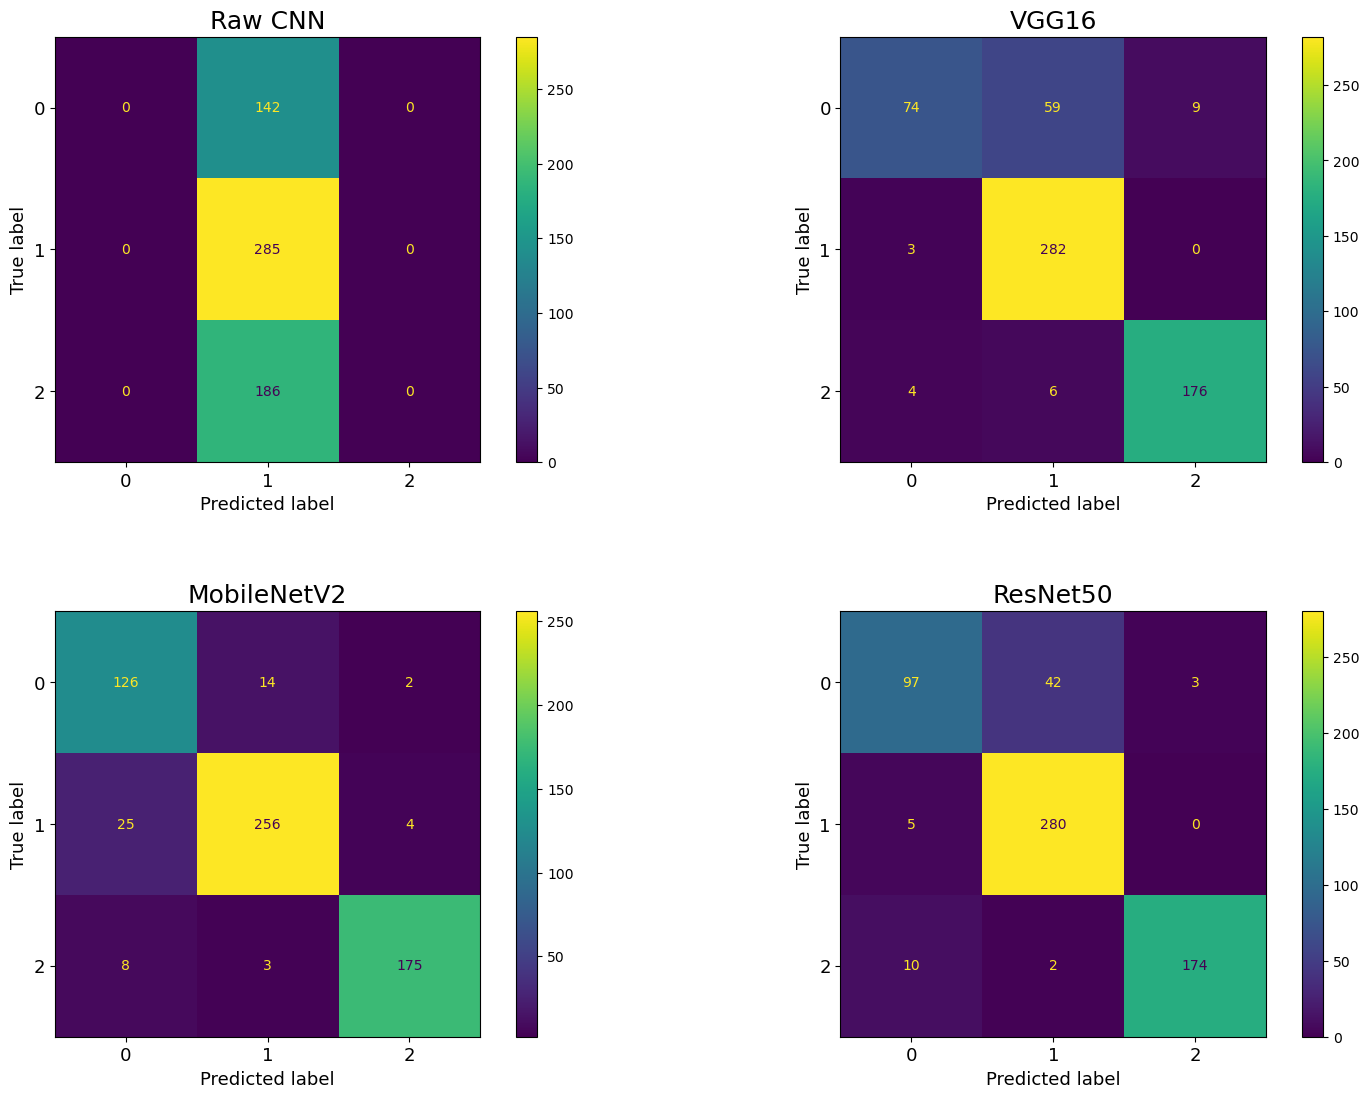

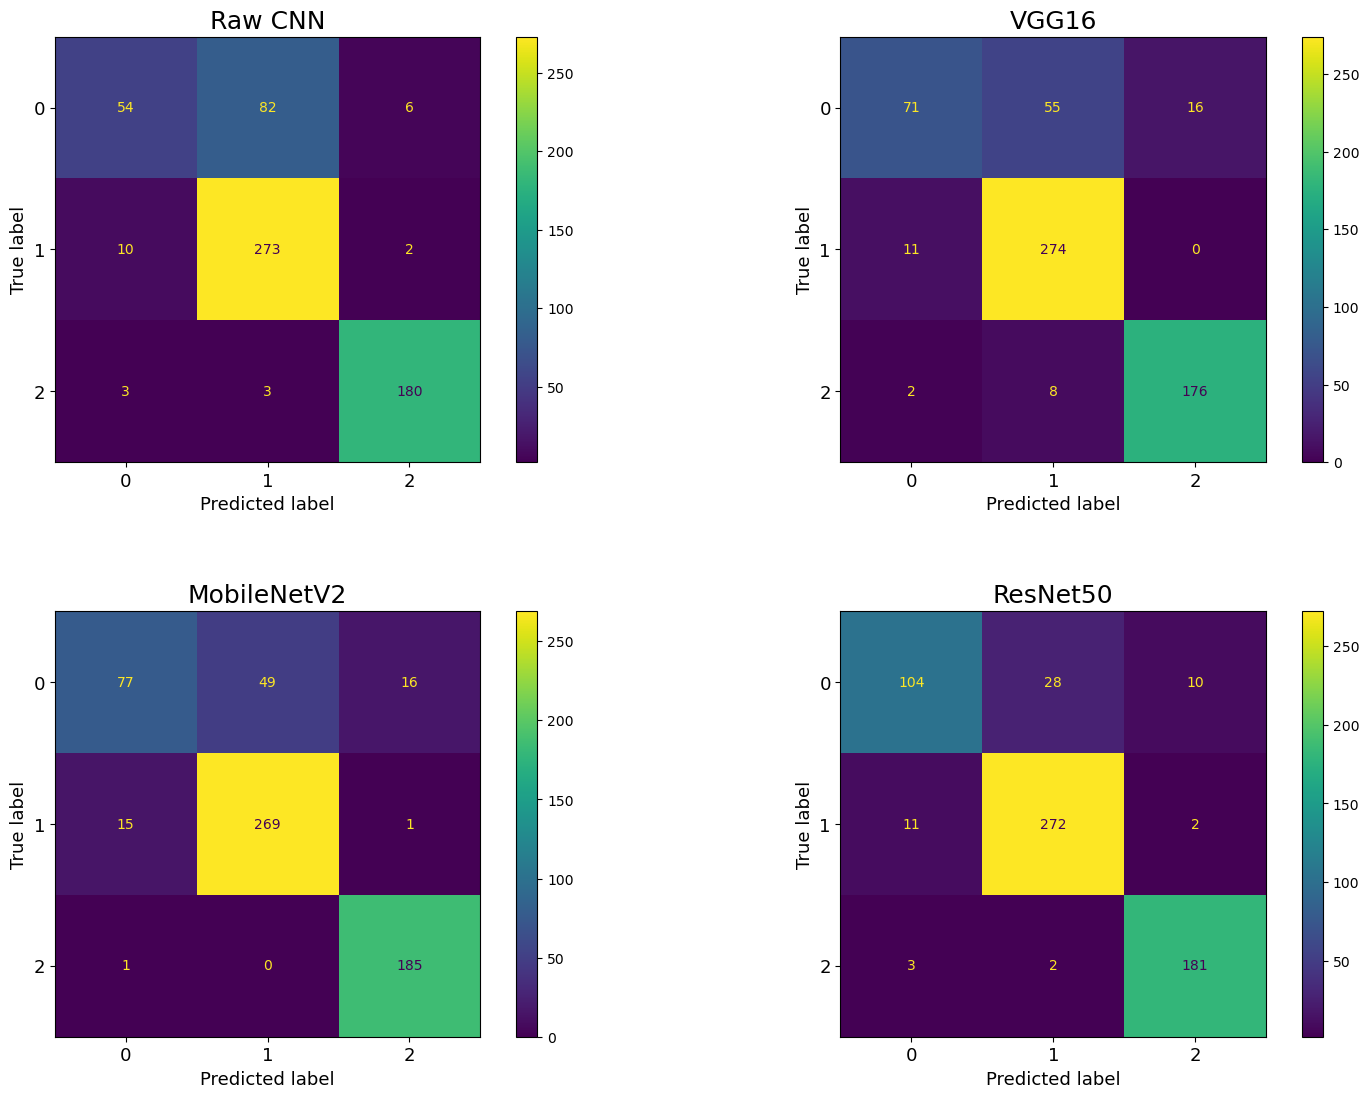

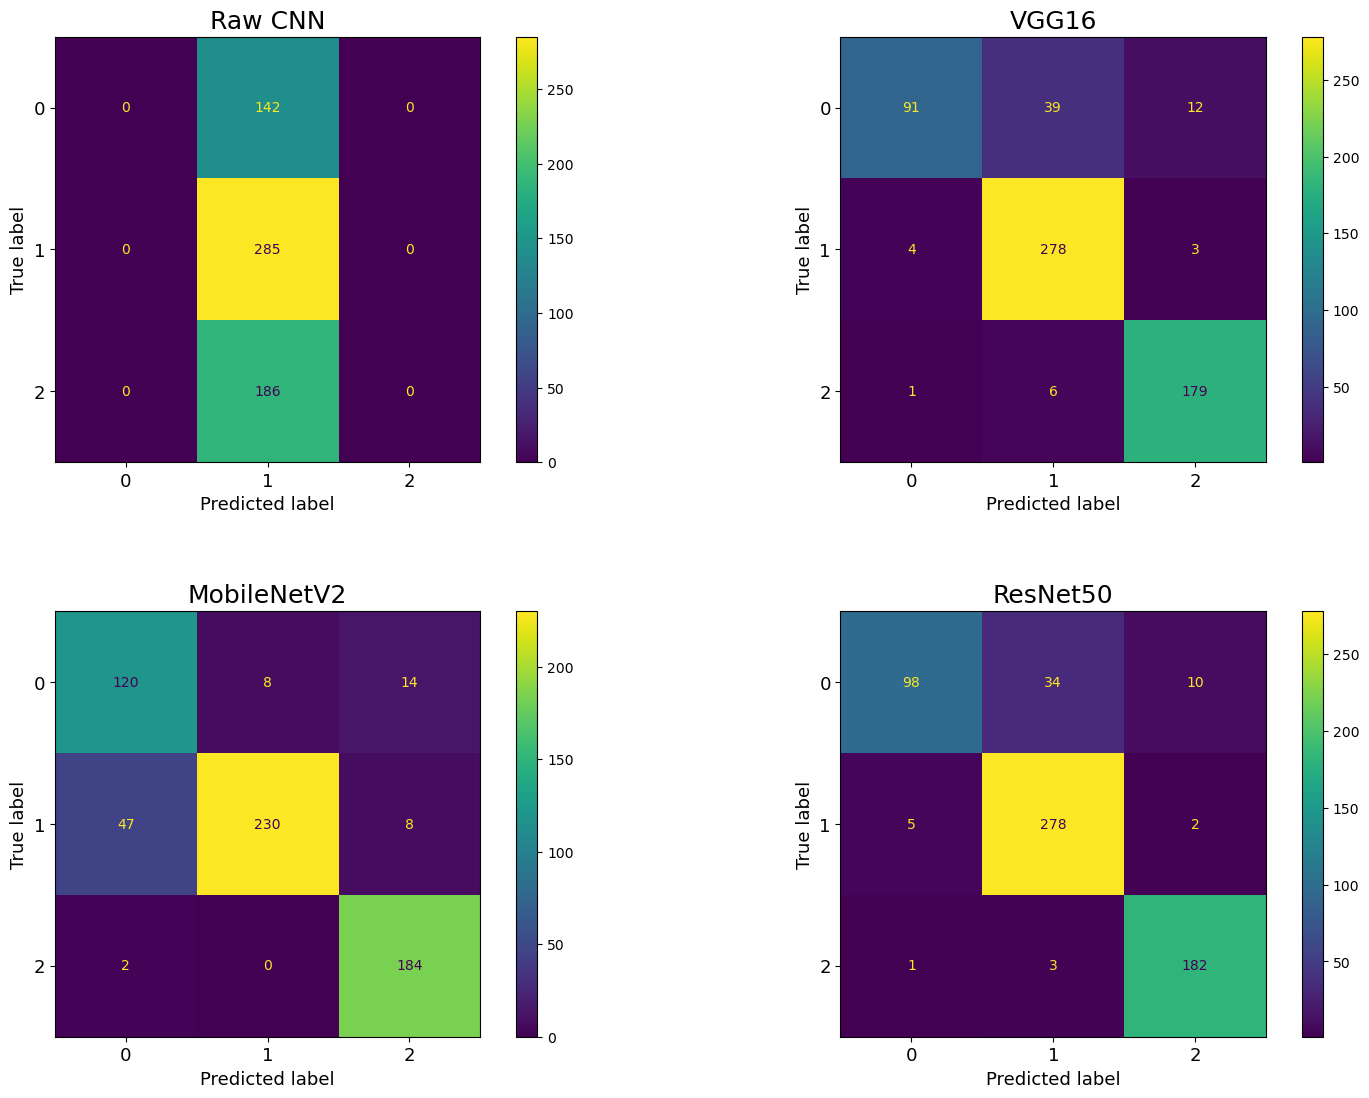

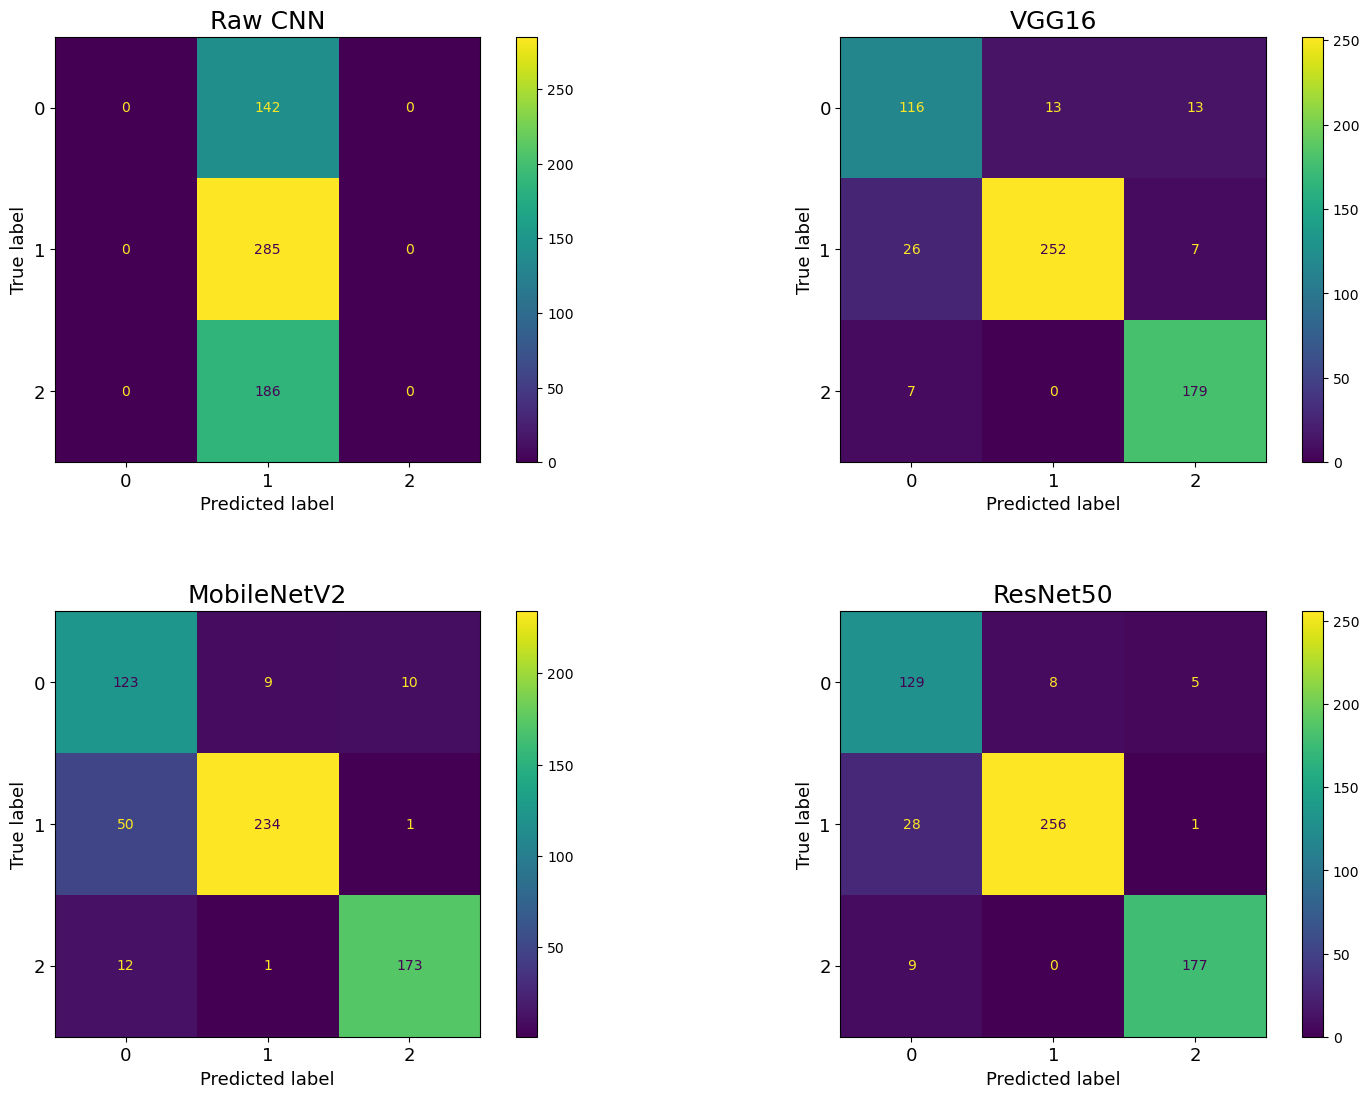

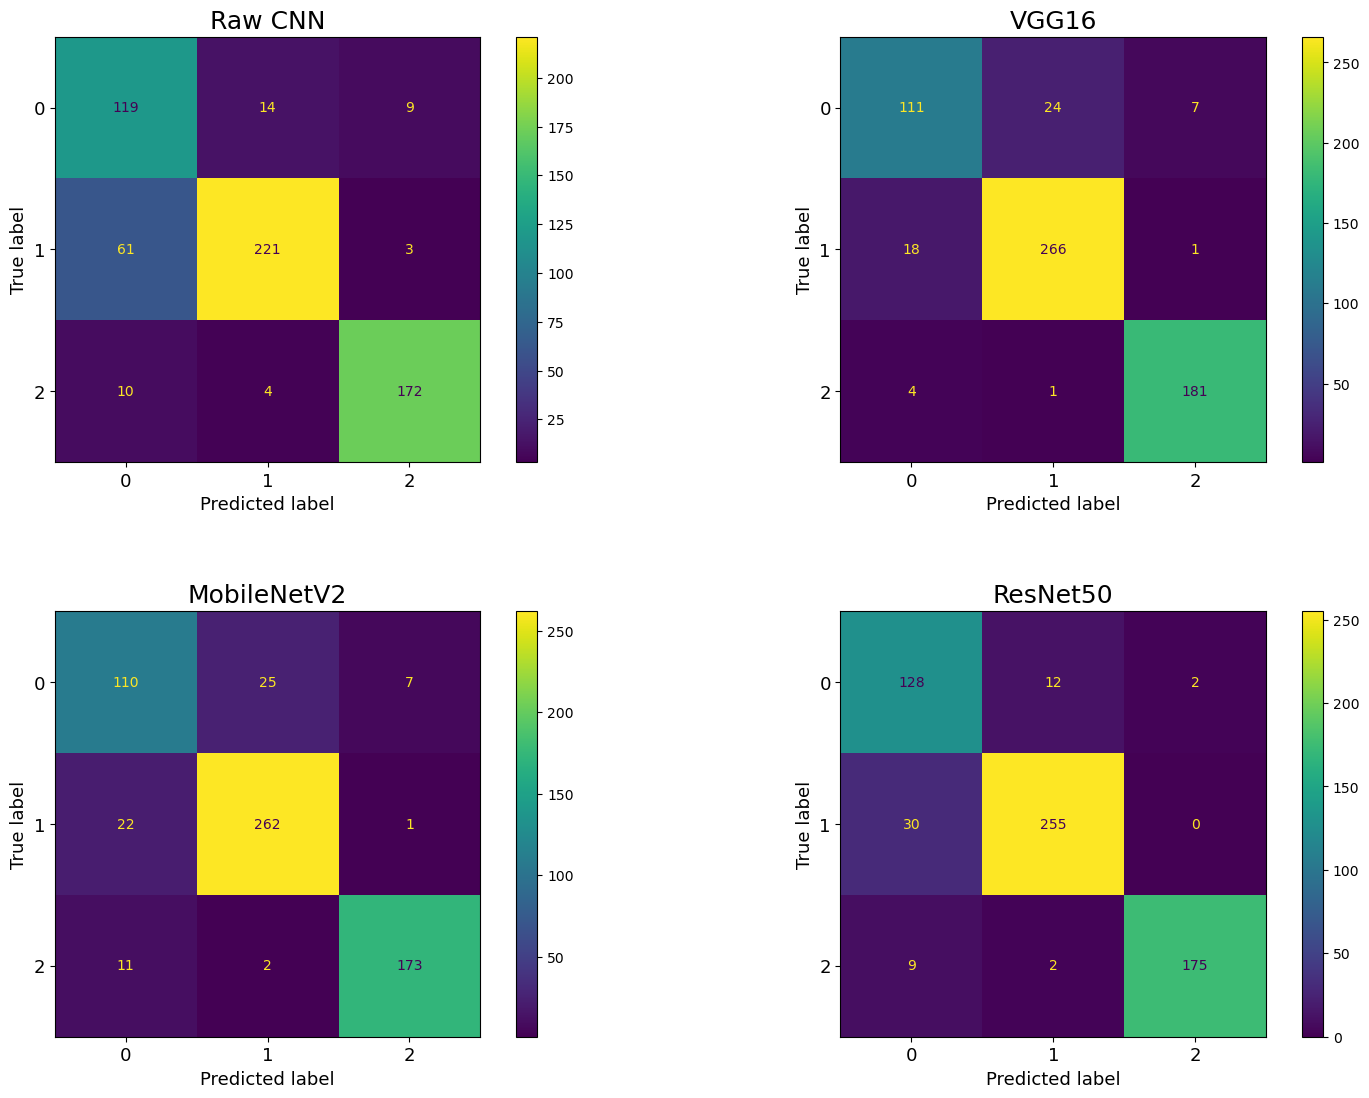

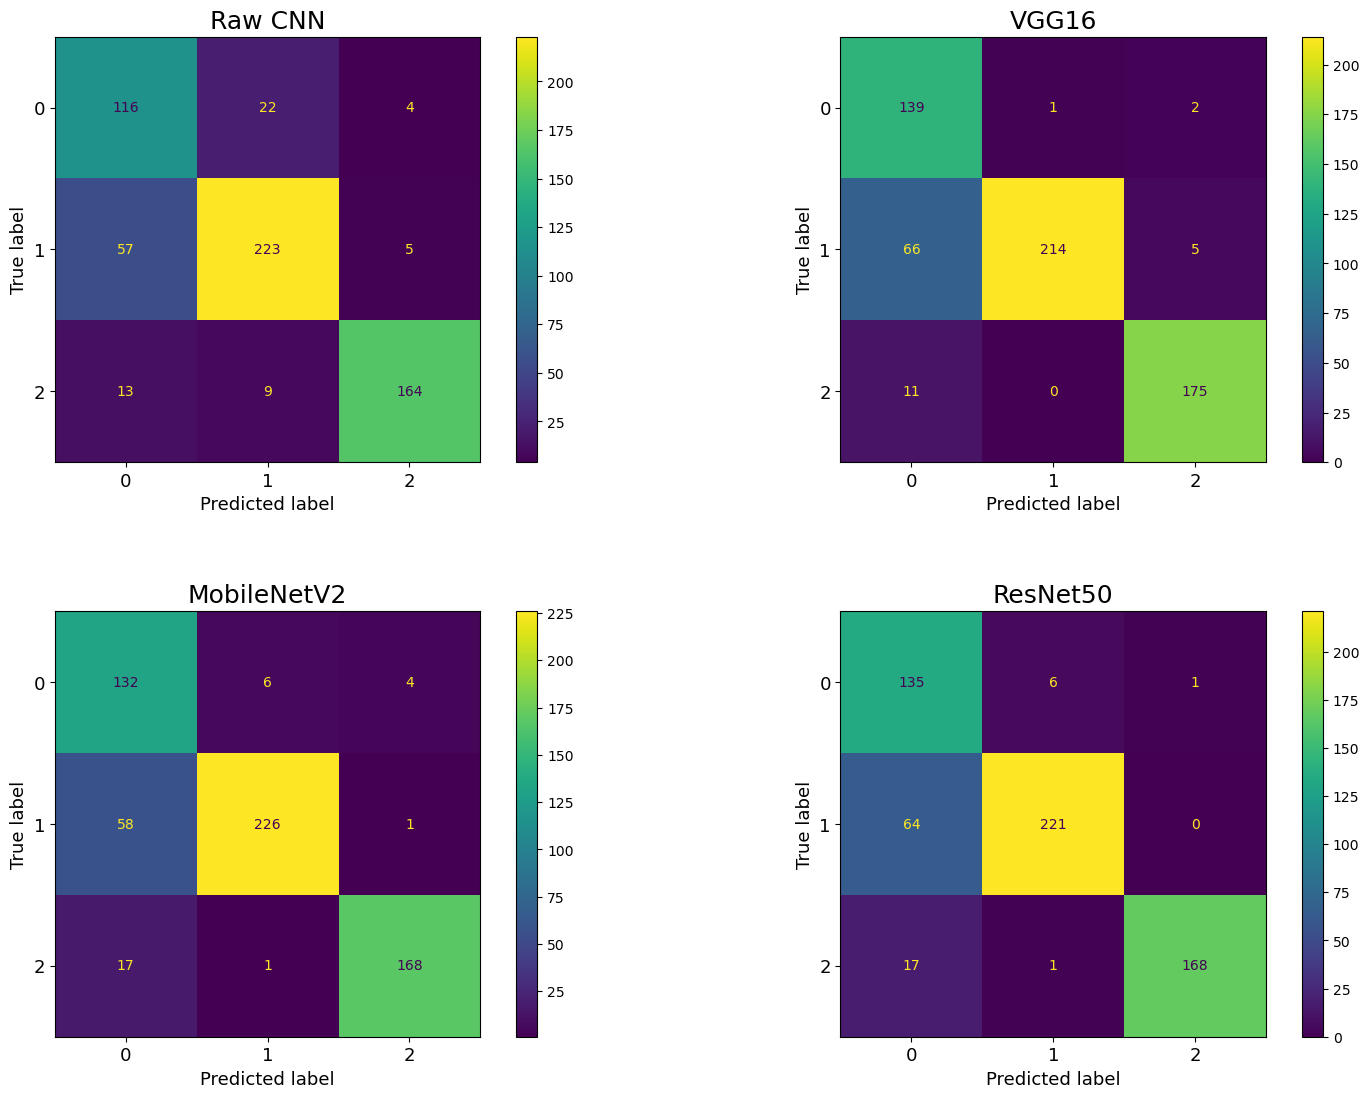

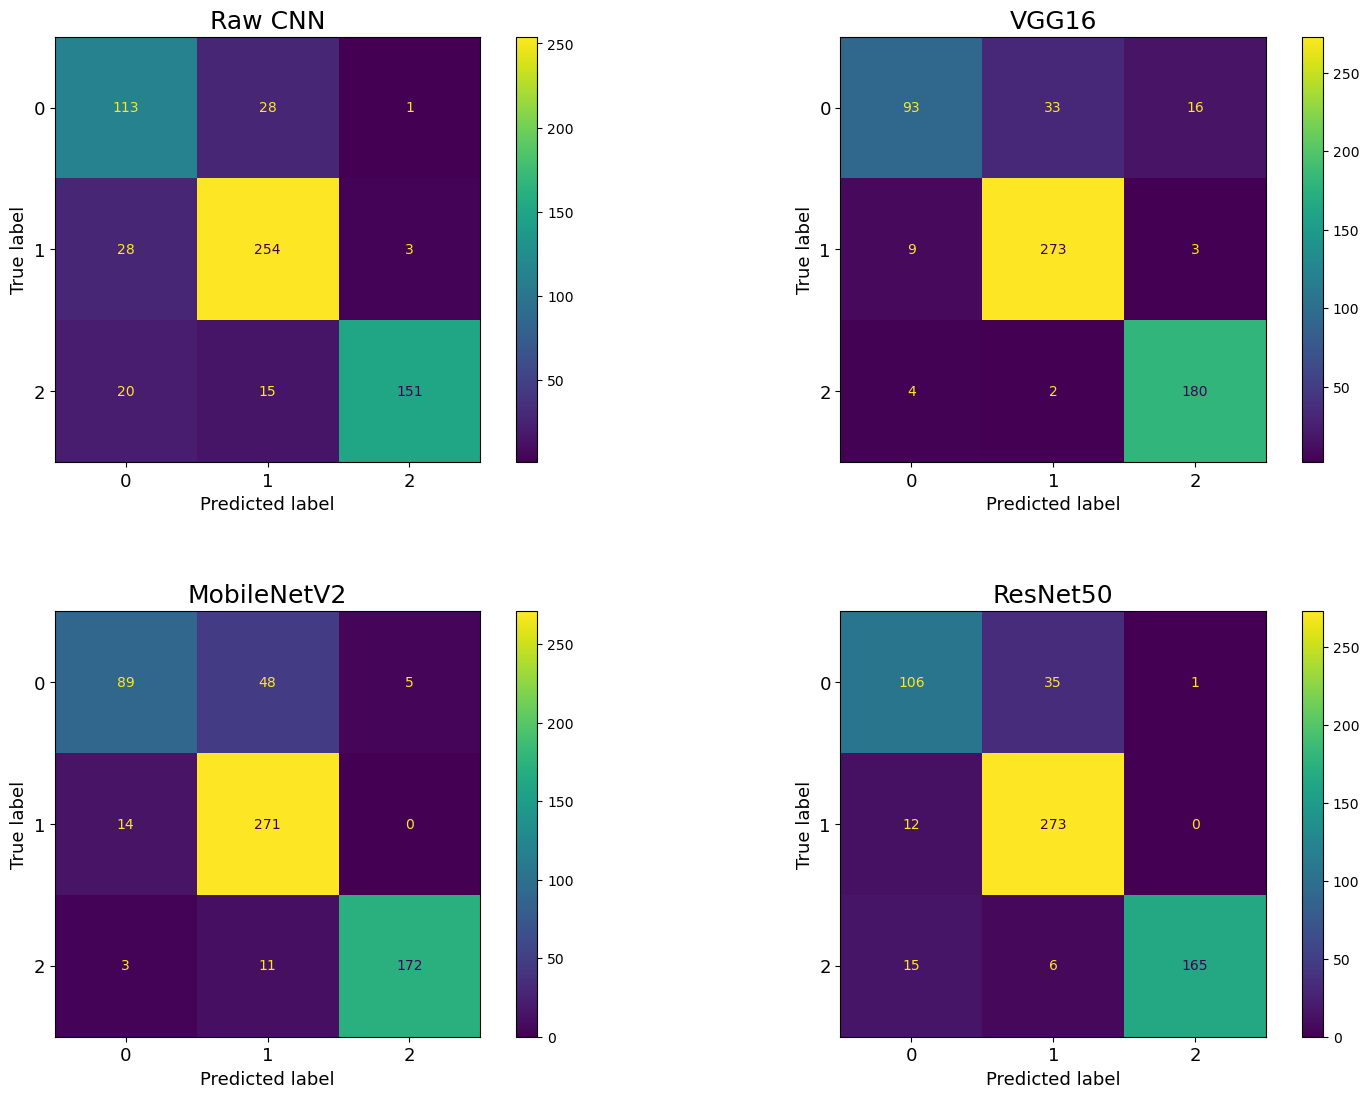

In [97]:
for split in range(sss_nsplits):
    visual.confusion_matrices([cnn_raw_cms[split], tl_vgg_cms[split], tl_mn_cms[split], tl_rn_cms[split]],
                              nrows=2, 
                              ncols=2, 
                              figsize=(15,10),
                              title_size=title_size,
                              label_size=label_size,
                              titles=["Raw CNN", "VGG16", "MobileNetV2", "ResNet50"]
                              )
    
    plt.savefig(f"{logs_dir}/brain_tumor_conf_matrices_{split}.png", bbox_inches="tight")
    
    plt.show()